In this Notebook we attempt to examine the relationship between "objective" measures of beer quality (winning a major expert-judged award)
and subjective product ratings by a large group of consumers. In order to examine this relationship (if any), we used the Stanford Network Analysis Project RateBeer dataset that consists of nearly 3 million indiviudal consumer beer ratings spanning the years 2000-2012 (obtainable @ https://www.ratebeer.com/api.asp), and a list of World Beer Cup medal award winning beers from the same time period. RateBeer user ratings were evaluated in light of their award winning status to look for any evidence of associations between medal winning and statistically higher consumer sentiment (subjective ratings).

Specifically, we were interested in two questions:

    1. Are award winning beers/breweries consistently more highly rated than other beers/breweries?
    2. Does winning a major award seem to have any direct impact on consumer ratings of that beer, such that the beer's rating improves after an award win?

Analysis/statistics: Summary statistics for the whole dataset and the dataset broken down into parent/specific style categories with rating histograms/median rating scores for each rating category. Correlations for ratings over time and over ABVs were evaluated. Most of the statistical testing involve Boferroni corrected Mann-Whitney U tests of unweighted rating sums for populations of beers specifically comparing medal winning beers to other large populations of beers in the dataset. All this was done to accumulate a statistically supported group of data that would indicate that, on average, breweries/beer of high quality are recognized by consumers who use the RateBeer beer rating website through their accumulated rating data.

Answers to key investigative questions:

    1. Are award winning beers/breweries consistently more highly rated than other beers/breweries?
        
        No, not on average and certainly not consistently. Our statistical results suggest that the likelihood a particular award winning brewery/beer will outperform other breweries/beers in RateBeer ratings is often no better than a coin flip. That said, there is a contingent of especially high performing breweries that do significantly outperform their peers in terms of RateBeer ratings (in our case, about 45-55% of the medal winning beers/breweries we looked at in this investigation outperform other beers/breweries). For example: Iron Hill Brewery and Restaurant in Deleware won a staggering 14 different medals between 2002-2010 and also significantly outperformed their peers in every style category in which they had a beer in the RateBeer database. This suggests that, for some of the highest performing breweries, their objective quality is consistently recognized by at least a portion of the consumer population.

    2. Does winning a major award seem to have any direct impact on consumer ratings of that beer?

    No. There was almost no evidence that winning a World Beer Cup Medal improves consumer's subjective ratings of that beer. In some ways, this is a positive outcome, because it indicates that people's ratings of beers are not strongly influenced by forces outside of their own personal experience, such as expert opinion (or that people generally aren't aware of when a beer wins an award). For breweries though, it means that winning awards may not have a positive impact on sales and/or can't be used effectively as a marketing tool.
    

Summary conclusions: Based on this small analysis, there appears to be virtually no strong and consistent association between a measure of objective quality (medal winning) and consumer ratings. On average, medal winning beers did not consistently rate higher than non-medal winning beers when measured against all other beers in the same style category, or even non-award winning beers brewed by the same brewery. Moreover, the medal winning event itself seemed to have virtually no impact on winning beer ratings overall or close to the medal-winning event. That said, there is evidence of specific award winning beer/breweries outperforming their peers in the eyes of consumers, which suggests that for perhaps the most outstanding beers/breweries in the world (as judged by a population of beer consumers that would use a beer rating website), objective product quality appears to translate to statistically and consistenly higher consumer product ratings. There are several hypotheses for such a pattern that may warrent further investigation, but overall (and perhaps not surprisingly) it appears that objective indicators of product quality do not strongly/consistenly correlate to subjective opinion of that same product when the evaluation is heavily weighted by personal taste/other outside factors, such as their level of expertise in evaluating the product (connoisseurship).

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import random
import numpy as np
import re

In [2]:
#input file location
beer_data_path = "data/ratebeer.txt"

In [3]:
#data input, formatting, and other processing for initial dataframe generation

#define empty list and dictionary
data = []
current_data = {}

#read in our data file
with open (beer_data_path, 'r') as file:
    lines = file.readlines()
    
#process that raw data file as is so that it can be converted into a dataFrame
for line in lines:
    line = line.strip()
    if not line:
        #a blank line indicates the end of one record
        data.append(current_data)
        current_data = {}
    else:
        parts = line.split(': ', 1)
        if len(parts) == 2:
            key, value = parts
            key = key.split('/')[1]  #extract our column headers from the data file and format; remove the two columns of no interest
            if key not in ('text'):
                if key in ('appearance', 'aroma', 'taste', 'palate', 'overall'):
                    value = value.replace('/5', '').replace('/10', '').replace('/20', '')
                current_data[key] = value

# Create a dataframe from the list of dictionaries 
beer_data_df = pd.DataFrame(data)

#add column for the year of the rating from the Unix timestamp
beer_data_df['year'] = pd.to_datetime(beer_data_df['time'].astype(float), unit='s').dt.year

#convert the columns that have number values to numeric dtypes
num_columns_to_convert = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'ABV']
beer_data_df[num_columns_to_convert] = beer_data_df[num_columns_to_convert].apply(pd.to_numeric, errors='coerce')

#cull any missing data
beer_data_df_cleaned = beer_data_df.dropna()

#remove non-beer styles
styles_to_drop = ['Cider', 'Ice Cider/Perry', 'Mead', 'Perry', 'Saké - Daiginjo', 'Saké - Futsu-shu', 'Saké - Genshu', 'Saké - Ginjo', 'Saké - Honjozo', 'Saké - Infused', 'Saké - Junmai', 'Saké - Koshu', 'Saké - Namasaké', 'Saké - Nigori', 'Saké - Taru', 'Saké - Tokubetsu']
style_filtered_data_df = beer_data_df_cleaned[~beer_data_df_cleaned['style'].isin(styles_to_drop)]

#add parent categories for every beer to reduce the style complexity a bit and make analysis more manageable - Use BCJP 2021 Style Guidelines
# Create a new empty column
style_filtered_data_df['parentStyle'] = None

# Define the words to search for and their corresponding string values
style_parent_mapping = {
    'Abbey Dubbel': 'Monastic Ale',
    'Abbey Tripel': 'Monastic Ale',
    'Abt/Quadrupel': 'Monastic Ale',
    'Altbier': 'Amber Bitter European Beer',
    'Amber Ale': 'Amber and Brown American Beer',
    'American Dark Lager': 'Standard American Beer',
    'American Pale Ale': 'Pale American Ale',
    'American Strong Ale': 'Strong American Ale',
    'Baltic Porter': 'Strong European Beer',
    'Barley Wine': 'Strong American Ale',
    'Belgian Ale': 'Belgian Ale',
    'Belgian Strong Ale': 'Strong Belgian Ale',
    'Belgian White &#40;Witbier&#41;': 'Belgian Ale',
    'Berliner Weisse': 'European Sour Ale',
    'Bitter': 'British Bitter', 
    'Bière de Garde': 'Belgian Ale',
    'Black IPA': 'IPA',
    'Bohemian Pilsener': 'Czech Lager',
    'Brown Ale': 'Amber and Brown American Beer',
    'California Common': 'Amber and Brown American Beer',
    'Classic German Pilsener': 'Pale Bitter European Beer',
    'Cream Ale': 'Standard American Beer',
    'Doppelbock': 'Strong European Beer',
    'Dortmunder/Helles': 'Pale Bitter European Lager',
    'Dry Stout': 'Irish Beer',
    'Dunkel': 'Dark European Lager',
    'Dunkelweizen': 'German Wheat Beer',
    'Dunkler Bock': 'Amber Malty European Lager',
    'Eisbock': 'Strong European Beer',
    'English Pale Ale': 'Pale Commonwealth Beer',
    'English Strong Ale': 'Strong British Ale',
    'Foreign Stout': 'Irish Beer',
    'Fruit Beer': 'Fruit Beer',
    'German Hefeweizen': 'German Wheat Beer',
    'German Kristallweizen': 'German Wheat Beer',
    'Golden Ale/Blond Ale': 'Pale American Ale',
    'Heller Bock': 'Pale Malty European Lager',
    'Imperial Stout': 'American Porter and Stout',
    'Imperial/Double IPA': 'Strong American Ale',
    'Imperial/Strong Porter': 'Strong American Ale',
    'India Pale Ale &#40;IPA&#41;': 'IPA',
    'Irish Ale': 'Irish Beer',
    'Kölsch': 'Pale Bitter European Beer',
    'Lambic - Faro': 'European Sour Ale',
    'Lambic - Fruit': 'European Sour Ale',
    'Lambic - Gueuze': 'European Sour Ale',
    'Lambic - Unblended': 'European Sour Ale',
    'Low Alcohol': 'Low or Non-Alcoholic Beer',
    'Malt Liquor': 'Standard American Beer',
    'Mild Ale': 'Brown British Beer',
    'Oktoberfest/Märzen': 'Amber Malty European Lager',
    'Old Ale': 'Strong British Ale',
    'Pale Lager': 'International Lager', 
    'Pilsener': 'International Lager', 
    'Porter': 'American Porter and Stout',
    'Premium Bitter/ESB': 'British Bitter',
    'Premium Lager': 'Standard American Beer',
    'Saison': 'Strong Belgian Ale',
    'Schwarzbier': 'Dark European Lager',
    'Scotch Ale': 'Strong British Ale', 
    'Scottish Ale': 'Scottish Ale',
    'Smoked': 'Smoked Beer',
    'Sour Ale/Wild Ale': 'American Wild Ale',
    'Specialty Grain': 'Alternative Fermentables Beer',
    'Spice/Herb/Vegetable': 'Spiced Beer',
    'Stout': 'American Porter and Stout',
    'Strong Pale Lager/Imperial Pils': 'International Lager',
    'Sweet Stout': 'Dark British Beer', 
    'Traditional Ale': 'Historical Beer',
    'Vienna': 'Amber Bitter European Beer', 
    'Weizen Bock': 'German Wheat Beer',
    'Wheat Ale': 'Standard American Beer',
    'Zwickel/Keller/Landbier': 'Historical Beer'
}

#define function to find style matches and update the new parent style column
def update_column(row):
    style = row['style']
    parent_category = style_parent_mapping.get(style, None)
    return parent_category

#apply the function to update the new parent style column
style_filtered_data_df['parentStyle'] = style_filtered_data_df.apply(update_column, axis=1)

#create a sum score for some simpler comparisons - unuweighted score of all of the indiviudal ratings for a beer
style_filtered_data_df['scoreSum'] = style_filtered_data_df[['appearance', 'aroma', 'palate', 'taste', 'overall']].sum(axis=1)

#make sure string values are strings
cols_to_string = ['name', 'beerId', 'brewerId', 'profileName']
beer_data_df[cols_to_string] = beer_data_df[cols_to_string].astype('string')

#output the dataset to a CSV file so we only need to run this cell once
current_directory = os.getcwd()
output_directory_name = "output_data"
directory_path = os.path.join(current_directory, output_directory_name)

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

style_filtered_data_df.to_csv("output_data/cleaned_beer_ratings.csv", index=False)

#display dataframe
style_filtered_data_df

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16344\3807901856.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  style_filtered_data_df['parentStyle'] = None
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16344\3807901856.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  style_filtered_data_df['parentStyle'] = style_filtered_data_df.apply(update_column, axis=1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16344\3807901856.py:136: SettingWithCopyWarning: 
A value is trying to be set 

,name,beerId,brewerId,ABV,style,appearance,aroma,palate,taste,overall,time,profileName,year,parentStyle,scoreSum
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4,6,3,6,13,1157587200,hopdog,2006,IPA,32
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,4,6,4,7,13,1157241600,TomDecapolis,2006,IPA,34
2,John Harvards Cristal Pilsner,71716,8481,5.0,Bohemian Pilsener,4,5,3,6,14,958694400,PhillyBeer2112,2000,Czech Lager,32
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,2,4,2,4,8,1157587200,TomDecapolis,2006,Pale Bitter European Beer,20
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,2,4,2,4,8,1157587200,hopdog,2006,Pale Bitter European Beer,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924158,Oakhill Mendip Twister,12240,1028,6.3,Stout,3,7,3,7,15,1013731200,rauchbier,2002,American Porter and Stout,35
2924159,Oakhill Yeoman 1767 Strong Ale,5677,1028,5.0,Premium Bitter/ESB,4,5,3,6,12,1074816000,imdownthepub,2004,British Bitter,30
2924160,Oakhill Yeoman 1767 Strong Ale,5677,1028,5.0,Premium Bitter/ESB,4,4,3,6,13,1050796800,SilkTork,2003,British Bitter,30
2924161,Oakhill Yeoman 1767 Strong Ale,5677,1028,5.0,Premium Bitter/ESB,3,5,2,5,10,1016409600,omhper,2002,British Bitter,25


In [4]:
#some summary statistics for the entire, mostly raw dataset (only dropped rows with missing data)

#read in csv file
beer_data_df_cleaned = pd.read_csv("output_data/cleaned_beer_ratings.csv", low_memory=False)

beer_data_df_cleaned['name'] = beer_data_df_cleaned['name'].str.strip().str.lower()
beer_data_df_cleaned['parentStyle'] = beer_data_df_cleaned['parentStyle'].str.strip().str.lower()
beer_data_df_cleaned['style'] = beer_data_df_cleaned['style'].str.strip().str.lower()

#whole dataset sampling summary
totalratings_sum = len(beer_data_df_cleaned)
totalratings_mean = beer_data_df_cleaned.groupby('beerId').size().mean()
totalABV_mean = beer_data_df_cleaned.drop_duplicates('beerId')['ABV'].mean()
totalratings_mean_round = round(totalratings_mean, 0)
totalABV_mean_round = round(totalABV_mean, 2)

#display whole dataset sampling summary
print(f'Total # ratings: {totalratings_sum}')
print(f'Average # ratings (per product): {totalratings_mean_round}')
print(f'Average ABV: {totalABV_mean_round}%')

#by parent style sampling summary
pstyle_totalratings_sum = beer_data_df_cleaned.groupby('parentStyle').size()
pstyle_totalratings_mean = beer_data_df_cleaned.groupby('parentStyle').size().mean()
pstyleABV_mean = beer_data_df_cleaned.drop_duplicates('beerId').groupby('parentStyle')['ABV'].mean()
pstyle_totalratings_mean_round = round(pstyle_totalratings_mean, 0)
pstyleABV_mean_round = round(pstyleABV_mean, 2)

#display parent style sampling summary
print()
print(f'Total # ratings: {pstyle_totalratings_sum}')
print()
print(f'Average ratings # (per parent style): {pstyle_totalratings_mean_round}')
print()
print(f'Average ABV (%): {pstyleABV_mean_round}')

#by style summary
style_totalratings_sum = beer_data_df_cleaned.groupby('style').size()
style_totalratings_mean = beer_data_df_cleaned.groupby('style').size().mean()
styleABV_mean = beer_data_df_cleaned.drop_duplicates('beerId').groupby('style')['ABV'].mean()
style_totalratings_mean_round = round(style_totalratings_mean, 0)
styleABV_mean_round = round(styleABV_mean, 2)

#display style sampling summary
print()
print(f'Total # ratings: {style_totalratings_sum}')
print()
print(f'Average ratings # (per style): {style_totalratings_mean_round}')
print()
print(f'Average ABV (%): {styleABV_mean_round}')

#by year summary
year_totalratings_sum = beer_data_df_cleaned.groupby('year').size()
year_totalratings_mean = beer_data_df_cleaned.groupby('year').size().mean()
year_totalratings_mean_round = round(year_totalratings_mean, 0)

#display by year sampling summary
print()
print(f'Total # ratings: {year_totalratings_sum}')
print()
print(f'Average # ratings (per year): {year_totalratings_mean_round}')

Total # ratings: 2750509
Average # ratings (per product): 33.0
Average ABV: 5.78%

Total # ratings: parentStyle
alternative fermentables beer     14634
amber and brown american beer    130462
amber bitter european beer        39739
amber malty european lager        56956
american porter and stout        269290
american wild ale                 44095
belgian ale                      110965
british bitter                   138435
brown british beer                12676
czech lager                       16433
dark british beer                 37016
dark european lager               46345
european sour ale                 25894
fruit beer                        75913
german wheat beer                 97788
historical beer                   30732
international lager              191029
ipa                              190633
irish beer                        47461
low or non-alcoholic beer         10304
monastic ale                     100042
pale american ale                158687
pale bit

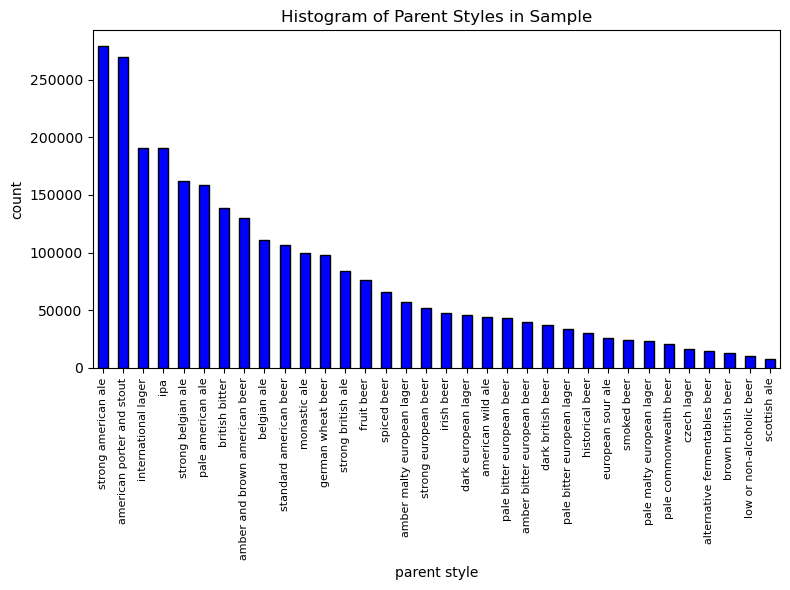

Sample distribution of beer ratings grouped by parent style


In [5]:
#distribution of sample sizes per parent category as number of ratings per category
plt.figure(figsize=(8, 6))  # Set the size of the plot
beer_data_df_cleaned['parentStyle'].value_counts().plot(kind='bar', color='blue', edgecolor='black')

plt.title('Histogram of Parent Styles in Sample')  # Set the plot title
plt.xlabel('parent style')  # Set the x-axis label
plt.ylabel('count')  # Set the y-axis label
plt.xticks(fontsize=8)
plt.tight_layout()
plt.show()
print('Sample distribution of beer ratings grouped by parent style')

In [6]:
#define a function to calculate the range of ratings for each rating category
def calculate_range(series):
    return series.max() - series.min()

#define a function to calculate the mode for each rating category
def calculate_mode(series):
    return series.mode().iloc[0] 
    
#summary statistics for each rating category for the entire dataset
overall_SS = beer_data_df_cleaned.agg({
    'appearance': ['median', calculate_mode, calculate_range],
    'aroma': ['median', calculate_mode, calculate_range],
    'palate': ['median', calculate_mode, calculate_range],
    'taste': ['median', calculate_mode, calculate_range],
    'overall': ['median', calculate_mode, calculate_range],
    'scoreSum': ['median', calculate_mode, calculate_range]
})

ss_wholedataset_df = pd.DataFrame(overall_SS)
ss_wholedataset_df = ss_wholedataset_df.T
ss_wholedataset_df.columns = ['Median Score', 'Score Mode', 'Score Range']
print('Whole dataset rating summary statistics')
print()
print(ss_wholedataset_df)

Whole dataset rating summary statistics

            Median Score  Score Mode  Score Range
appearance           3.0         3.0          4.0
aroma                7.0         7.0          9.0
palate               3.0         3.0          4.0
taste                7.0         7.0          9.0
overall             14.0        14.0         19.0
scoreSum            34.0        35.0         45.0



Score frequency histograms and median for every ratings category and every beer in the dataset



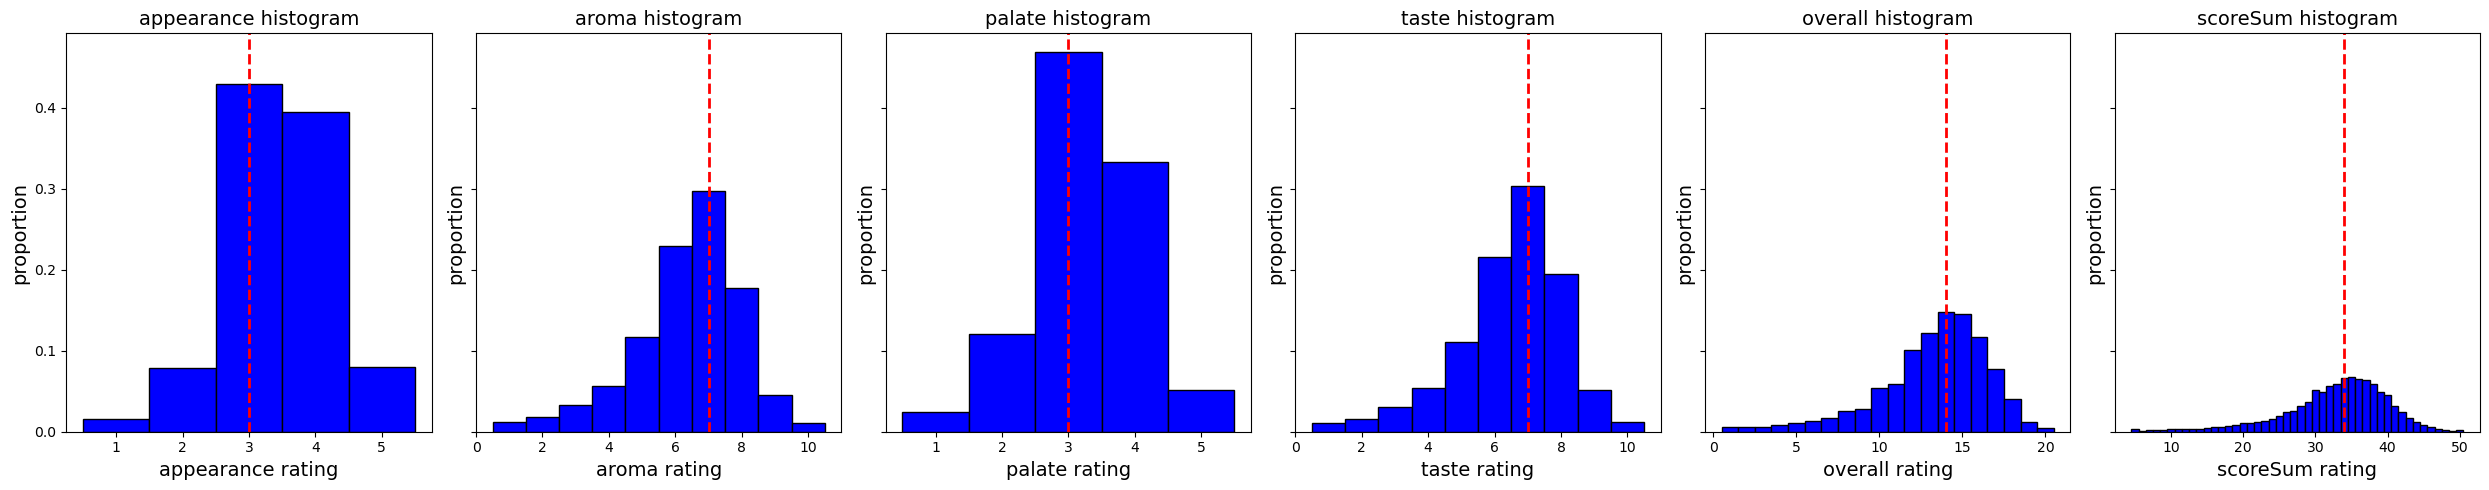

In [7]:
#show ratings score frequency histograms for whole dataset with median as red dashed line
fig, axes = plt.subplots(1, 6, figsize=(25, 5), sharey=True)

# Create histograms for each column
for i, column in enumerate(['appearance', 'aroma', 'palate', 'taste', 'overall', 'scoreSum']):
    values = beer_data_df_cleaned[column]
    
    if column == 'appearance' or column == 'palate':
        bins = np.arange(0.5, 6, 1)  # For 1-5 scale
    elif column == 'aroma' or column == 'taste':
        bins = np.arange(0.5, 11, 1)  # For 1-10 scale
    elif column == 'overall':
        bins = np.arange(0.5, 21, 1)  # For 1-20 scale
    else:
        bins = np.arange(4.5, 51, 1)  # For 5-50 scale
    
    ax = axes[i]
    ax.hist(values, bins=bins, color='blue', edgecolor='black', density=True)  # Use density=True
    ax.set_xlabel(f'{column} rating', fontsize=14)
    ax.set_ylabel('proportion', fontsize=14)
    ax.set_title(f'{column} histogram', fontsize=14)

# Calculate the median value
    median = np.median(values)

    # Add a vertical line at the median
    ax.axvline(median, color='red', linestyle='dashed', linewidth=2, label='Median')

# Show the histograms
print()
print('Score frequency histograms and median for every ratings category and every beer in the dataset')
print()
plt.tight_layout()
plt.show()

In [8]:
#summary statistics for each rating category for the parent styles
pivot_table_pstyle = beer_data_df_cleaned.pivot_table(beer_data_df_cleaned, index='parentStyle', aggfunc={'appearance': ['median', calculate_mode, calculate_range],
                                                        'aroma': ['median', calculate_mode, calculate_range],
                                                        'palate': ['median', calculate_mode, calculate_range],
                                                        'taste': ['median', calculate_mode, calculate_range],
                                                        'overall': ['median', calculate_mode, calculate_range],
                                                        'scoreSum': ['median', calculate_mode, calculate_range]})

# Rename the columns for clarity
pivot_table_pstyle.columns = ['_'.join(col).strip() for col in pivot_table_pstyle.columns.values]

#display pivot table
pivot_table_pstyle

,appearance_calculate_mode,appearance_calculate_range,appearance_median,aroma_calculate_mode,aroma_calculate_range,aroma_median,overall_calculate_mode,overall_calculate_range,overall_median,palate_calculate_mode,palate_calculate_range,palate_median,scoreSum_calculate_mode,scoreSum_calculate_range,scoreSum_median,taste_calculate_mode,taste_calculate_range,taste_median
parentStyle,,,,,,,,,,,,,,,,,,
alternative fermentables beer,3,4,3.0,7,9,6.0,14,19,13.0,3,4,3.0,34,45,33.0,7,9,7.0
amber and brown american beer,3,4,3.0,6,9,6.0,14,19,13.0,3,4,3.0,34,45,32.0,7,9,6.0
amber bitter european beer,3,4,3.0,6,9,6.0,13,19,13.0,3,4,3.0,30,45,31.0,6,9,6.0
amber malty european lager,3,4,3.0,6,9,6.0,13,19,13.0,3,4,3.0,30,45,32.0,6,9,6.0
american porter and stout,4,4,4.0,7,9,7.0,15,19,15.0,4,4,4.0,38,45,37.0,7,9,7.0
american wild ale,4,4,4.0,8,9,8.0,16,19,16.0,4,4,4.0,40,45,38.0,8,9,8.0
belgian ale,3,4,3.0,7,9,7.0,14,19,14.0,3,4,3.0,34,45,33.0,7,9,7.0
british bitter,3,4,3.0,6,9,6.0,13,19,13.0,3,4,3.0,30,45,31.0,6,9,6.0
brown british beer,3,4,3.0,6,9,6.0,13,19,13.0,3,4,3.0,32,45,32.0,7,9,6.0


Frequency histograms and median value for all parent categories for each rating grouped by the parent style



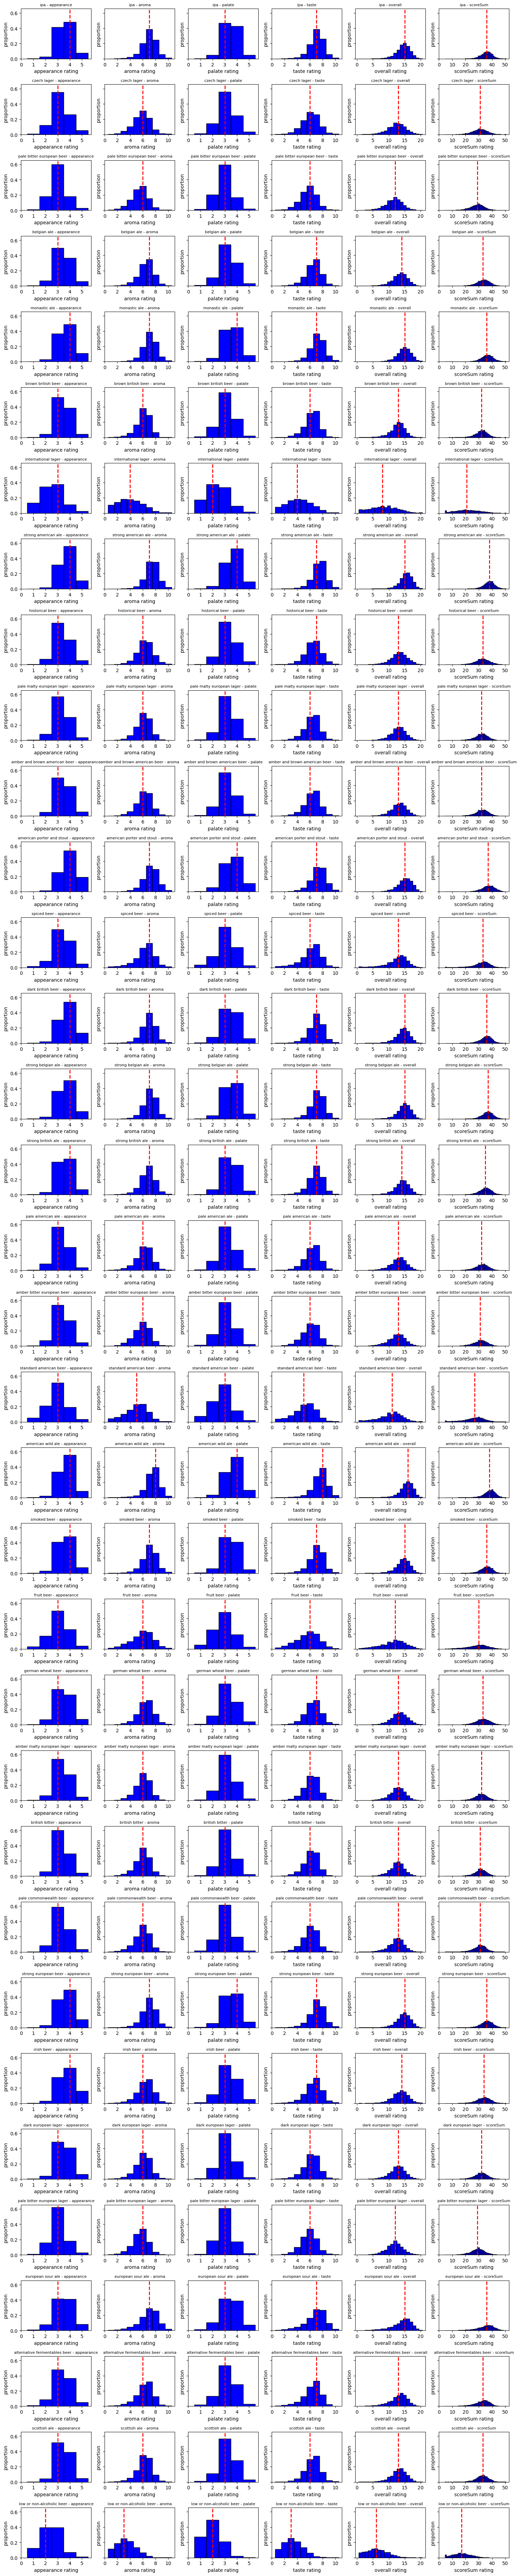

In [9]:
#summary frequency histograms for all of parent styles by rating category
parent_styles = beer_data_df_cleaned['parentStyle'].unique().astype(str)

# Create a figure and subplots for the grouped histograms
fig, axes = plt.subplots(len(parent_styles), 6, figsize=(15, 75), sharey=True)

# Create grouped histograms for each parent style category
for i, parent_style in enumerate(parent_styles):
    parentStyle_df = beer_data_df_cleaned[beer_data_df_cleaned['parentStyle'] == parent_style]

    for j, column in enumerate(['appearance', 'aroma', 'palate', 'taste', 'overall', 'scoreSum']):
        values = parentStyle_df[column]

        if column == 'appearance' or column == 'palate':
            bins = np.arange(0.5, 6.5, 1)  # For 1-5 scale
            x_ticks = np.arange(0, 6)
        elif column == 'aroma' or column == 'taste':
            bins = np.arange(0.5, 11.5, 1)  # For 1-10 scale
            x_ticks = np.arange(0, 12, 2)
        elif column == 'overall':
            bins = np.arange(0.5, 21.5, 1)  # For 1-20 scale
            x_ticks = np.arange(0, 25, 5)
        else:
            bins = np.arange(4.5, 51.5, 1)  # For 5-50 scale
            x_ticks = np.arange(0, 60, 10)

        ax = axes[i, j]
        n, bins, patches = ax.hist(values, bins=bins, color='blue', edgecolor='black', density=True)
        ax.set_xlabel(f'{column} rating')
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks)
        ax.set_ylabel('proportion')
        ax.set_title(parent_style + ' - ' + column, fontsize=8)

# Calculate the median value
        median = np.median(values)

        # Add a vertical line at the median
        ax.axvline(median, color='red', linestyle='dashed', linewidth=2, label='Median')

# Show the grouped histograms
plt.tight_layout()
print('Frequency histograms and median value for all parent categories for each rating grouped by the parent style')
print()
plt.show()

In [10]:
#Kruskal-Wallace test for significant differences in the unweighted score sum across parent categories
grouped_data = {group: data['scoreSum'] for group, data in beer_data_df_cleaned.groupby('parentStyle')}
statistic, p_value = st.kruskal(*grouped_data.values())
p_display_threshold = 0.0001

# Format the p-value output
if p_value < p_display_threshold:
    formatted_p_value = f"p < {p_display_threshold:.4f}"
else:
    formatted_p_value = f"p = {p_value:.4f}"

# Display the test results
print(f"Kruskal-Wallis Test Statistic: {statistic}")
print(f"P-Value: {formatted_p_value}")

if p_value < 0.05:
    print("The Kruskal-Wallis test indicates significant differences between the groups.")
else:
    print("The Kruskal-Wallis test does not indicate significant differences between the groups.")

Kruskal-Wallis Test Statistic: 828630.313365723
P-Value: p < 0.0001
The Kruskal-Wallis test indicates significant differences between the groups.


In [11]:
#calculate the overall median for all parent style categories
overall_median = beer_data_df_cleaned['scoreSum'].median()
agg_grouped = beer_data_df_cleaned.groupby('parentStyle')['scoreSum'].median()

#extract the unique parent style categories from the filtered DataFrame
selected_parentstyles = agg_grouped[agg_grouped > overall_median].sort_values(ascending=False).index.tolist()

#print the list of selected parent style categories that have a score sum above the median
print('Parent styles with median summed score above the median for all beer parent style categories (descending order)')
print('--------------------------------------------------------------------------------------------------------------')
print(selected_parentstyles)

selected_parentstyles = agg_grouped[agg_grouped < overall_median].sort_values(ascending=True).index.tolist()

#print the list of selected parent style categories that have a score sum below the median
print()
print('Parent styles with median summed score below the median for all beer parent style categories (descending order)')
print('--------------------------------------------------------------------------------------------------------------')
print(selected_parentstyles)

Parent styles with median summed score above the median for all beer parent style categories (descending order)
--------------------------------------------------------------------------------------------------------------
['american wild ale', 'strong american ale', 'american porter and stout', 'strong belgian ale', 'dark british beer', 'european sour ale', 'ipa', 'monastic ale', 'smoked beer', 'strong european beer', 'strong british ale']

Parent styles with median summed score below the median for all beer parent style categories (descending order)
--------------------------------------------------------------------------------------------------------------
['low or non-alcoholic beer', 'international lager', 'standard american beer', 'pale bitter european beer', 'pale bitter european lager', 'fruit beer', 'british bitter', 'czech lager', 'pale commonwealth beer', 'amber bitter european beer', 'brown british beer', 'amber malty european lager', 'pale malty european lager', 'amber an

In [12]:
#summary statistics for each beer style category for the entire dataset
pivot_table_style = beer_data_df_cleaned.pivot_table(beer_data_df_cleaned, index='style', aggfunc={'appearance': ['median', calculate_mode, calculate_range],
                                                        'aroma': ['median', calculate_mode, calculate_range],
                                                        'palate': ['median', calculate_mode, calculate_range],
                                                        'taste': ['median', calculate_mode, calculate_range],
                                                        'overall': ['median', calculate_mode, calculate_range],
                                                        'scoreSum': ['median', calculate_mode, calculate_range]})

#rename the columns for clarity
pivot_table_style.columns = ['_'.join(col).strip() for col in pivot_table_style.columns.values]

#display pivot table
pivot_table_style

,appearance_calculate_mode,appearance_calculate_range,appearance_median,aroma_calculate_mode,aroma_calculate_range,aroma_median,overall_calculate_mode,overall_calculate_range,overall_median,palate_calculate_mode,palate_calculate_range,palate_median,scoreSum_calculate_mode,scoreSum_calculate_range,scoreSum_median,taste_calculate_mode,taste_calculate_range,taste_median
style,,,,,,,,,,,,,,,,,,
abbey dubbel,4,4,4.0,7,9,7.0,15,19,15.0,3,4,3.0,37,45,36.0,7,9,7.0
abbey tripel,4,4,4.0,7,9,7.0,15,19,15.0,4,4,4.0,37,45,36.0,7,9,7.0
abt/quadrupel,4,4,4.0,8,9,8.0,16,19,16.0,4,4,4.0,38,45,39.0,8,9,8.0
altbier,3,4,3.0,6,9,6.0,14,19,13.0,3,4,3.0,32,45,33.0,7,9,6.0
amber ale,3,4,3.0,6,9,6.0,14,19,13.0,3,4,3.0,30,45,32.0,7,9,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
traditional ale,3,4,3.0,7,9,7.0,14,19,14.0,3,4,3.0,35,45,34.0,7,9,7.0
vienna,3,4,3.0,6,9,6.0,12,19,12.0,3,4,3.0,30,45,30.0,6,9,6.0
weizen bock,4,4,4.0,7,9,7.0,15,19,15.0,4,4,4.0,37,45,37.0,7,9,7.0


In [13]:
#more data filtering and adjusting for correlation analysis
#define function to remove ABV outliers based on ABV IQR for each beer style
def remove_outliers(group):
    Q1 = group['ABV'].quantile(0.25)
    Q3 = group['ABV'].quantile(0.75)
    IQR = Q3 - Q1
    return group[(group['ABV'] >= Q1 - 1.5 * IQR) & (group['ABV'] <= Q3 + 1.5 * IQR)]

noOutlier_beer_data_indy_df = beer_data_df_cleaned.groupby('style', group_keys=False).apply(remove_outliers)

#output the dataset to a CSV file so we only need to run this cell once
current_directory = os.getcwd()
output_directory_name = "output_data"
directory_path = os.path.join(current_directory, output_directory_name)

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

#output the outlier culled data to csv file
noOutlier_beer_data_indy_df.to_csv("output_data/noOutlier_indy_beer_ratings.csv", index=False)

In [14]:
#define function for displaying scatterplot and Spearman rank correlation calc for each rating variable
def performSpearmanCorr(df, x_column, y_column):

    x = df[x_column]
    y = df[y_column]

    spearman_corr, spearman_p_value = st.spearmanr(x, y)

    formatted_spearman_corr = '{:.2f}'.format(round(spearman_corr,2)) #round to two decimal places for visual pleasure
    formatted_spearman_p_value = '{:.5f}'.format(round(spearman_p_value,5)) 

    print()
    plt.scatter(x, y)
    plt.xlabel(x_column)
    plt.ylabel(f'{y_column} rating')
    plt.title(f'{x_column} versus {y_column} rating')
    plt.tight_layout()
    print()
    plt.show()
    print(f'The Spearman rank correlation between {x_column} and the {y_column} is {formatted_spearman_corr} with a P-value of {formatted_spearman_p_value}')

In [15]:
#read in csv files from above
noOutlier_beer_data_indy_df = pd.read_csv("output_data/noOutlier_indy_beer_ratings.csv", low_memory=False)

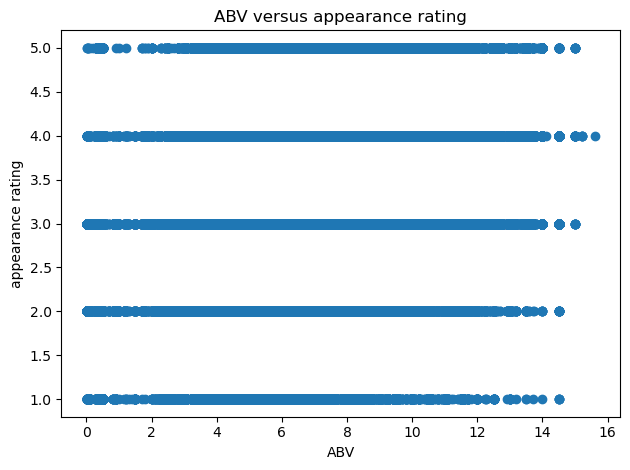

The Spearman rank correlation between ABV and the appearance is 0.33 with a P-value of 0.00000




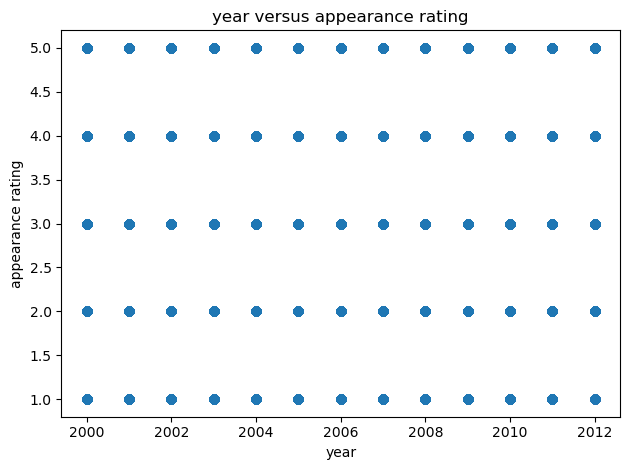

The Spearman rank correlation between year and the appearance is 0.02 with a P-value of 0.00000


In [16]:
#spearman correlations for all rating categories versus ABV (for funsies)

#raw ratings correlation appearance - Spearman because of ordinal response variable
performSpearmanCorr(noOutlier_beer_data_indy_df, 'ABV', 'appearance')
performSpearmanCorr(noOutlier_beer_data_indy_df, 'year', 'appearance')

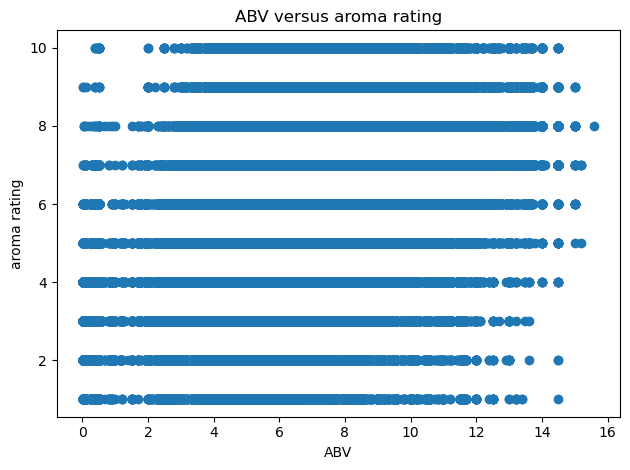

The Spearman rank correlation between ABV and the aroma is 0.47 with a P-value of 0.00000




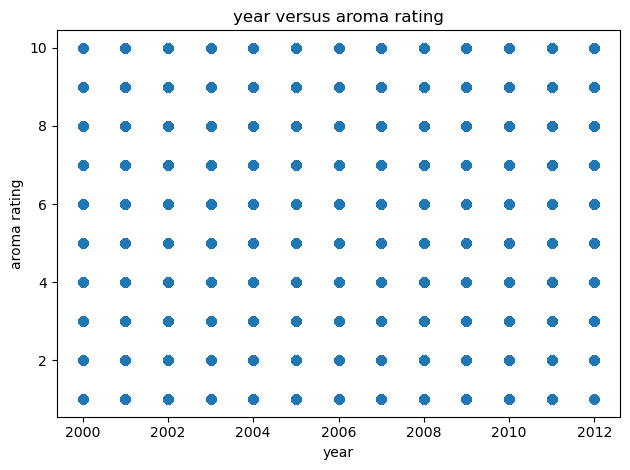

The Spearman rank correlation between year and the aroma is 0.07 with a P-value of 0.00000


In [17]:
#raw ratings correlation aroma vs ABV - Spearman because of ordinal response variable
performSpearmanCorr(noOutlier_beer_data_indy_df, 'ABV', 'aroma')
performSpearmanCorr(noOutlier_beer_data_indy_df, 'year', 'aroma')

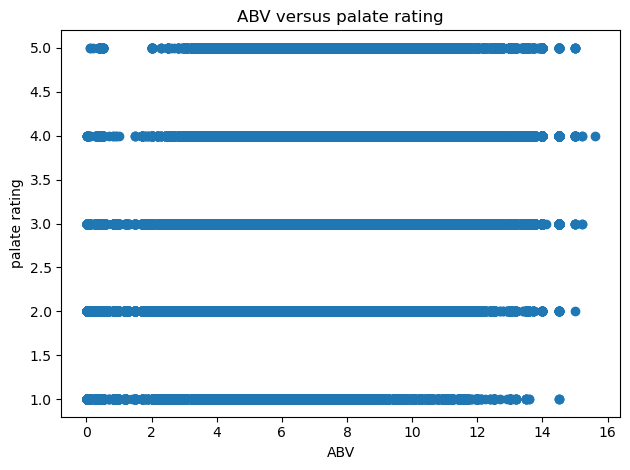

The Spearman rank correlation between ABV and the palate is 0.37 with a P-value of 0.00000




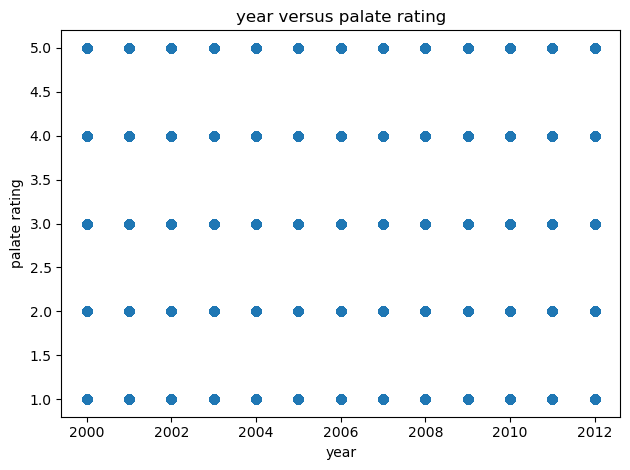

The Spearman rank correlation between year and the palate is 0.06 with a P-value of 0.00000


In [18]:
#raw ratings correlation palate vs ABV - Spearman because of ordinal response variable
performSpearmanCorr(noOutlier_beer_data_indy_df, 'ABV', 'palate')
performSpearmanCorr(noOutlier_beer_data_indy_df, 'year', 'palate')

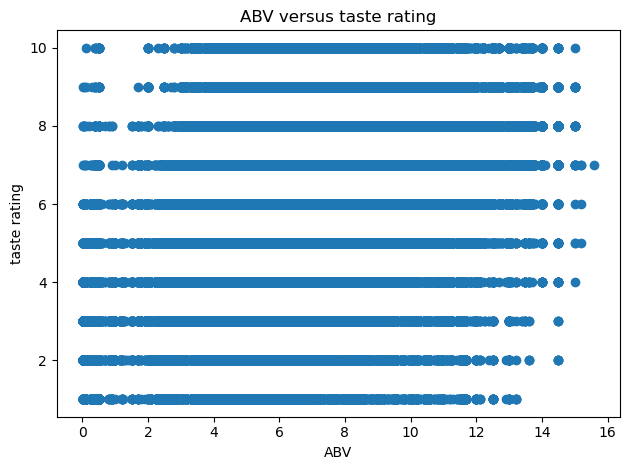

The Spearman rank correlation between ABV and the taste is 0.44 with a P-value of 0.00000




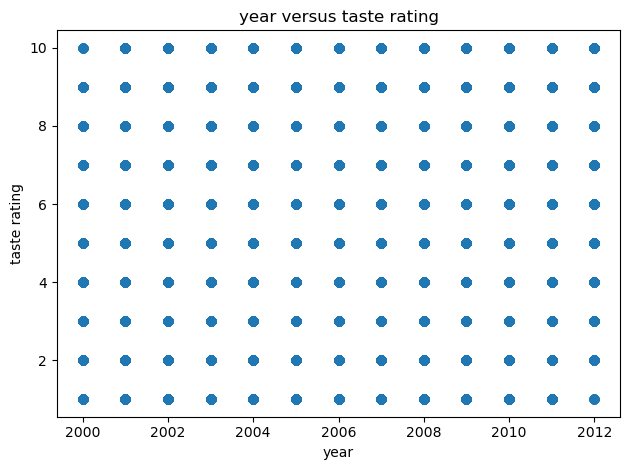

The Spearman rank correlation between year and the taste is 0.06 with a P-value of 0.00000


In [19]:
#raw ratings correlation taste vs ABV - Spearman because of ordinal response variable
performSpearmanCorr(noOutlier_beer_data_indy_df, 'ABV', 'taste')
performSpearmanCorr(noOutlier_beer_data_indy_df, 'year', 'taste')

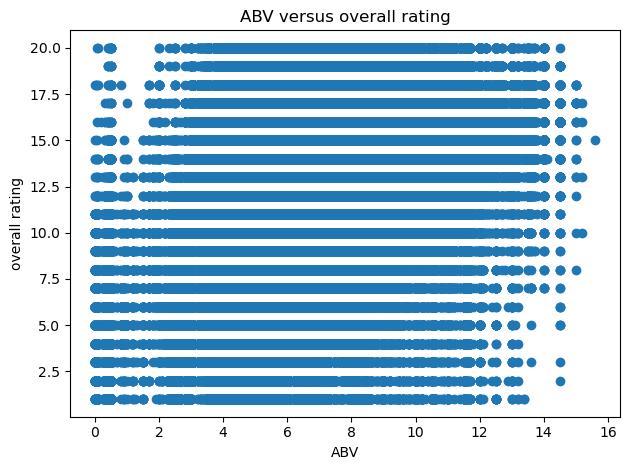

The Spearman rank correlation between ABV and the overall is 0.47 with a P-value of 0.00000




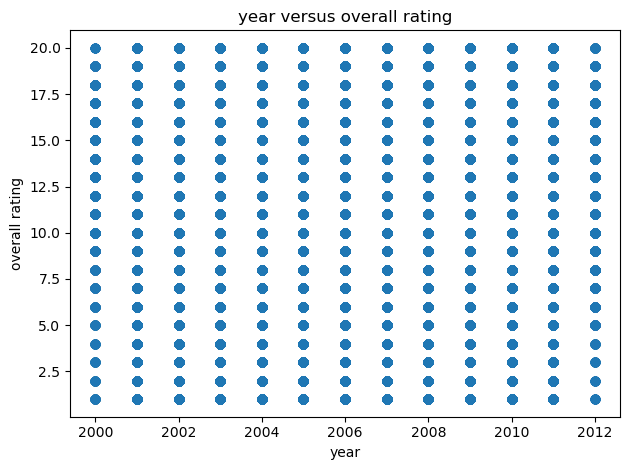

The Spearman rank correlation between year and the overall is 0.05 with a P-value of 0.00000


In [20]:
#raw ratings correlation overall vs ABV - Spearman because of ordinal response variable
performSpearmanCorr(noOutlier_beer_data_indy_df, 'ABV', 'overall')
performSpearmanCorr(noOutlier_beer_data_indy_df, 'year', 'overall')

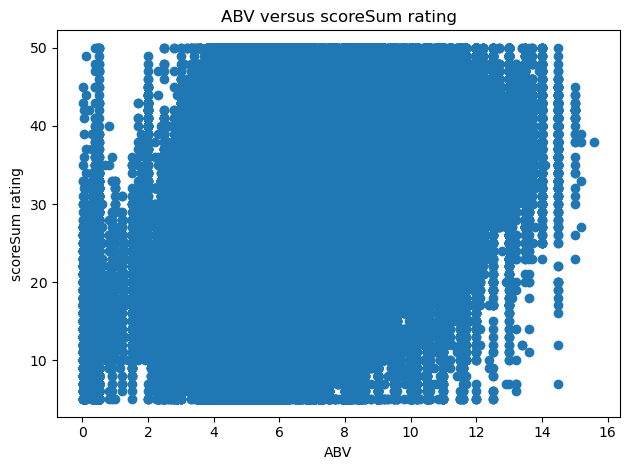

The Spearman rank correlation between ABV and the scoreSum is 0.50 with a P-value of 0.00000




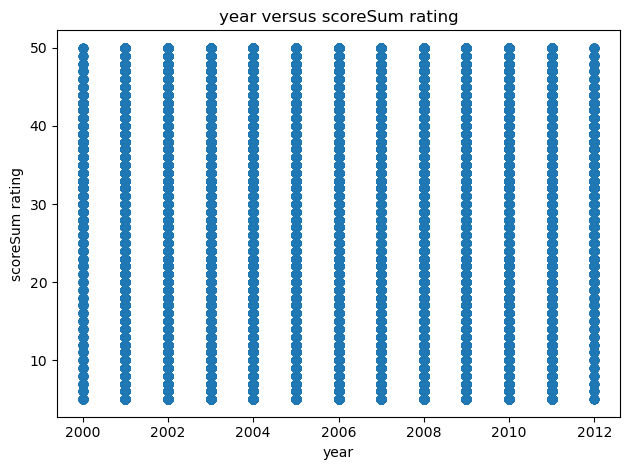

The Spearman rank correlation between year and the scoreSum is 0.06 with a P-value of 0.00000


In [21]:
#raw ratings correlation scoreSum vs ABV - Spearman because of ordinal response variable
performSpearmanCorr(noOutlier_beer_data_indy_df, 'ABV', 'scoreSum')
performSpearmanCorr(noOutlier_beer_data_indy_df, 'year', 'scoreSum')

In [22]:
#append medal data for medal-winning related statistical tests
wbc_medals_df = pd.read_csv("data/wbc2002-2010.csv")

wbc_medals_df['wbc_category'] = wbc_medals_df['wbc_category'].str.strip().str.lower()  # Remove leading/trailing white spaces
wbc_medals_df['medal'] = wbc_medals_df['medal'].str.strip().str.lower()
wbc_medals_df['wbc_name'] = wbc_medals_df['wbc_name'].str.strip().str.lower()
wbc_medals_df['wbc_brewery'] = wbc_medals_df['wbc_brewery'].str.strip().str.lower()
wbc_medals_df['wbctoratebeer_name_brewery'] = wbc_medals_df['wbctoratebeer_name_brewery'].str.strip().str.lower()

#merge the DataFrames on the 'wbctoratebeer_name_brewery' and 'name' columns
wbc_medal_merged_df = pd.merge(beer_data_df_cleaned, wbc_medals_df, left_on='name', right_on='wbctoratebeer_name_brewery', how='inner')

wbc_medal_merged_df

,name,beerId,brewerId,ABV,style,appearance,aroma,palate,taste,overall,...,profileName,year,parentStyle,scoreSum,wbc_category,wbc_year_win,medal,wbc_name,wbc_brewery,wbctoratebeer_name_brewery
0,kannah creek standing wave pale ale,71014,7314,5.2,american pale ale,5,7,5,7,16,...,onceblind,2011,pale american ale,40,esb,2008,gold,standing wave pale ale,kannah creek brewing co.,kannah creek standing wave pale ale
1,kannah creek standing wave pale ale,71014,7314,5.2,american pale ale,3,6,4,7,15,...,Zymurgeist2,2011,pale american ale,35,esb,2008,gold,standing wave pale ale,kannah creek brewing co.,kannah creek standing wave pale ale
2,kannah creek standing wave pale ale,71014,7314,5.2,american pale ale,4,7,4,7,15,...,hellbilly,2011,pale american ale,37,esb,2008,gold,standing wave pale ale,kannah creek brewing co.,kannah creek standing wave pale ale
3,kannah creek standing wave pale ale,71014,7314,5.2,american pale ale,4,8,4,8,16,...,beerguy101,2010,pale american ale,40,esb,2008,gold,standing wave pale ale,kannah creek brewing co.,kannah creek standing wave pale ale
4,kannah creek standing wave pale ale,71014,7314,5.2,american pale ale,3,6,3,6,13,...,jb43,2009,pale american ale,31,esb,2008,gold,standing wave pale ale,kannah creek brewing co.,kannah creek standing wave pale ale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77267,pyramid haywire hefeweizen,951,154,5.2,german hefeweizen,3,6,3,6,12,...,jerc,2010,german wheat beer,30,american style hefe,2006,bronze,pyramid hefeweizen,pyramid ales and lagers,pyramid haywire hefeweizen
77268,pyramid haywire hefeweizen,951,154,5.2,german hefeweizen,4,5,3,5,12,...,SSSteve,2010,german wheat beer,29,american style wheat,2002,silver,hefeweizen,pyramid ales and lagers,pyramid haywire hefeweizen
77269,pyramid haywire hefeweizen,951,154,5.2,german hefeweizen,4,5,3,5,12,...,SSSteve,2010,german wheat beer,29,american style hefe,2006,bronze,pyramid hefeweizen,pyramid ales and lagers,pyramid haywire hefeweizen
77270,pyramid haywire hefeweizen,951,154,5.2,german hefeweizen,3,5,3,5,10,...,rougeau13,2010,german wheat beer,26,american style wheat,2002,silver,hefeweizen,pyramid ales and lagers,pyramid haywire hefeweizen


In [23]:
#this section attempts to statistically examine the effect of winning a medal on a indivudal beer's ratings by looking at its sum score before and after
#winning a medal

#initialize a list to store the results
winner_results = []

#get unique combinations of 'name' and 'wbc_year_win' from the DataFrame
unique_winner_combinations = wbc_medal_merged_df[['name', 'wbc_year_win', 'medal', 'wbc_category']].drop_duplicates()

#loop through each unique combination
for index, row in unique_winner_combinations.iterrows():
    name = row['name']
    win_year = row['wbc_year_win']
    medal = row['medal']
    category = row['wbc_category']
    
    #get the two populations of interest for the Mann-Whitney U test (scoreSum before winning a medal and after)
    population_beforewin = wbc_medal_merged_df[(wbc_medal_merged_df['name'] == name) & (wbc_medal_merged_df['year'] <= win_year)]['scoreSum']
    population_afterwin = wbc_medal_merged_df[(wbc_medal_merged_df['name'] == name) & (wbc_medal_merged_df['year'] > win_year)]['scoreSum']

    #minimum sample size of three ratings per beer
    if len(population_beforewin) < 3 or len(population_afterwin) < 3: 
        continue
    
    #perform the one-tailed Mann-Whitney U test (we only really care about if the stochastic dominance is > after a medal win)
    statistic, p_value = st.mannwhitneyu(population_beforewin, population_afterwin, alternative='less')

    formatted_p_value = '{:.6f}'.format(p_value)
    
    winner_results.append({'Name': name, 'Medal Win Year': win_year, 'Medal Won': medal, 'Win Category': category,  'MWU Test Statistic': statistic, 'P-Value': formatted_p_value})

#create a DataFrame from the results list
medalwinner_results_df = pd.DataFrame(winner_results)

#display the results for each unique combination of 'name' and 'wbc_win_year'
medalwinner_results_df

,Name,Medal Win Year,Medal Won,Win Category,MWU Test Statistic,P-Value
0,kannah creek standing wave pale ale,2008,gold,esb,2.0,0.045962
1,firestone walker hefeweizen,2010,gold,german style hefe,111.5,0.118416
2,nectar ales pale nectar,2004,silver,american pale ale,1000.5,0.878088
3,mission street pale ale,2006,silver,american pale ale,11756.0,0.009175
4,mission street pale ale,2010,bronze,american pale ale,6936.0,0.006002
...,...,...,...,...,...,...
135,shiner hefeweizen,2002,bronze,american style wheat,55048.0,0.998693
136,shiner hefeweizen,2006,silver,american style hefe,242224.0,0.999998
137,pyramid crystal wheat,2008,gold,american style wheat,3808.0,0.022584
138,pyramid haywire hefeweizen,2002,silver,american style wheat,178822.0,1.000000


In [24]:
#check for evidence that, if beer ratings tend to be higher after a medal win, it occurs consistently 
#convert our P-values to numbers
medalwinner_results_df['P-Value'] = pd.to_numeric(medalwinner_results_df['P-Value'], errors='coerce')

#define your significant P-value threshold
significant_threshold = 0.05 / medalwinner_results_df['P-Value'].size

#categorize results as significant or non-significant
medalwinner_results_df['Result'] = medalwinner_results_df['P-Value'].apply(lambda x: 'Significant' if x < significant_threshold else 'Non-Significant')

medalwinner_results_df_sig = medalwinner_results_df['Result'] == 'Significant'
medalwinner_results_sig_df = medalwinner_results_df[medalwinner_results_df_sig]

medalwinner_results_sig_df

,Name,Medal Win Year,Medal Won,Win Category,MWU Test Statistic,P-Value,Result
8,firestone walker pale 31,2010,gold,american pale ale,94531.5,0.000270,Significant
44,boundary bay cabin fever,2006,bronze,strong ale,3775.5,0.000141,Significant
92,dogfish head festina lente,2006,bronze,belgian sour,2717.5,0.000000,Significant
110,russian river pliny the elder,2006,gold,imperial ipa,110426.5,0.000000,Significant


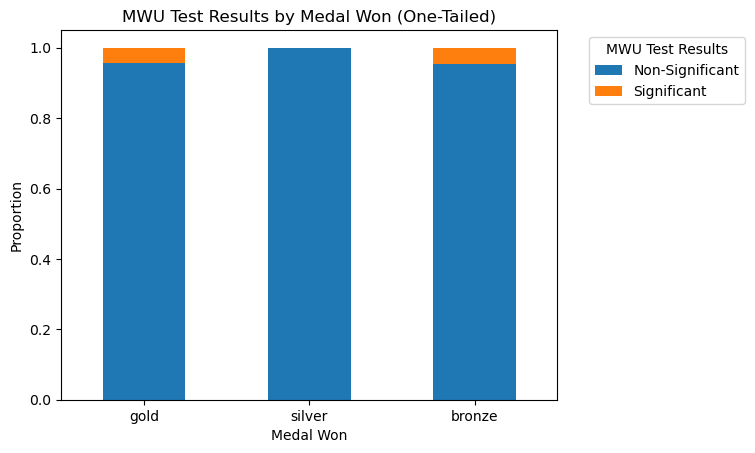

Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)


In [25]:
#check for evidence that, if beer ratings tend to be higher after a medal win, it occurs consistently

#group the data by the 'Medal Won' and 'Result' columns and count the results in each group
medal_grouped_results_df = medalwinner_results_df.groupby(['Medal Won', 'Result']).size().unstack().fillna(0)

#normalize for proportions
medal_grouped_results_df = medal_grouped_results_df.div(medal_grouped_results_df.sum(axis=1), axis=0)

#define the custom order for the groups
custom_group_order = ['gold', 'silver', 'bronze']

#reindex the grouped_data DataFrame to match the custom order
medal_grouped_results_df = medal_grouped_results_df.reindex(custom_group_order)

#create a stacked bar graph to display frequency of ratings significantly shifting after medal winning
medal_grouped_results_df.plot(kind='bar', stacked=True)
plt.xlabel('Medal Won')
plt.ylabel('Proportion')
plt.title('MWU Test Results by Medal Won (One-Tailed)')
plt.legend(title='MWU Test Results', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()
print('Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)')

In [26]:
#statistically evalute if the frequency of a significant increase in beer ratings is any better than a coin toss (if it happened at all)
#define the chi-square function
def cs(n, y):
    return st.chisquare(n, np.sum(n) / np.sum(y) * y)

#Calculate observed frequencies by grouping the data by 'Medal Won' and 'Result'
observed = medalwinner_results_df.groupby(['Medal Won', 'Result']).size().unstack(fill_value=0)

#Calculate the total counts within each 'Medal Won' category
total_counts = observed.sum(axis=1)

#Define the expected frequencies for 'Significant' and 'Non-Significant' as 50%-50%
expected = pd.DataFrame({
    'Significant': total_counts * 0.5,
    'Non-Significant': total_counts * 0.5
})

print(observed)
print()
print(expected)

#Perform the chi-square goodness of fit test using the cs function
chi2, p = cs(observed.values.ravel(), expected.values.ravel())

#Display the chi-square statistic and p-value
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")

#Determine whether to reject the null hypothesis
alpha = 0.05  # Significance level
if p < alpha:
    print("Reject the null hypothesis: The observed distribution is different from the expected 50%-50% distribution")
else:
    print("Fail to reject the null hypothesis: The observed distribution is not significantly different from the expected 50%-50% distribution")

Result     Non-Significant  Significant
Medal Won                              
bronze                  41            2
gold                    45            2
silver                  50            0

           Significant  Non-Significant
Medal Won                              
bronze            21.5             21.5
gold              23.5             23.5
silver            25.0             25.0
Chi-square statistic: 124.71
P-value: 0.0000
Reject the null hypothesis: The observed distribution is different from the expected 50%-50% distribution


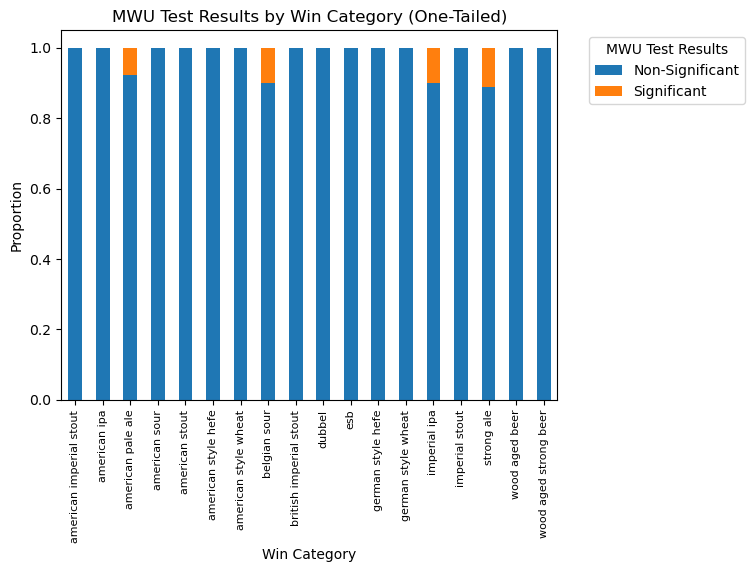

Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)


In [27]:
#do the above except now examine if win category influences the frequency of improved ratings after medal win
#group the data by the 'win category' and 'result' columns and count the results in each group
cat_grouped_results_df = medalwinner_results_df.groupby(['Win Category', 'Result']).size().unstack().fillna(0)

#normalize for proportions
cat_grouped_results_df = cat_grouped_results_df.div(cat_grouped_results_df.sum(axis=1), axis=0)

# Create a stacked bar graph
cat_grouped_results_df.plot(kind='bar', stacked=True)
plt.xlabel('Win Category')
plt.ylabel('Proportion')
plt.title('MWU Test Results by Win Category (One-Tailed)')
plt.legend(title='MWU Test Results', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90, fontsize=8)
plt.show()
print('Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)')

In [28]:
#chi-sqaure test to see if parent style's influence on scores after winning a medal is better than a coin flip
#calculate observed frequencies by grouping the data by 'Parent Style' and 'Result'
observed = medalwinner_results_df.groupby(['Win Category', 'Result']).size().unstack(fill_value=0)

#calculate the total counts within each 'Parent Style' category
total_counts = observed.sum(axis=1)

#define the expected frequencies for 'Significant' and 'Non-Significant' as 50%-50%
expected = pd.DataFrame({
    'Significant': total_counts * 0.5,
    'Non-Significant': total_counts * 0.5
})

print(observed)
print()
print(expected)

#perform the chi-square goodness of fit test using the cs function
chi2, p = cs(observed.values.ravel(), expected.values.ravel())

#display the chi-square statistic and p-value
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")

#determine whether to reject the null hypothesis
alpha = 0.05  # Significance level
if p < alpha:
    print("Reject the null hypothesis: The observed distribution is different from the expected 50%-50% distribution")
else:
    print("Fail to reject the null hypothesis: The observed distribution is not significantly different from the expected 50%-50% distribution")

Result                   Non-Significant  Significant
Win Category                                         
american imperial stout                6            0
american ipa                          14            0
american pale ale                     12            1
american sour                          3            0
american stout                         5            0
american style hefe                    9            0
american style wheat                  10            0
belgian sour                           9            1
british imperial stout                 3            0
dubbel                                 9            0
esb                                   10            0
german style hefe                      5            0
german style wheat                     8            0
imperial ipa                           9            1
imperial stout                         7            0
strong ale                             8            1
wood aged beer              

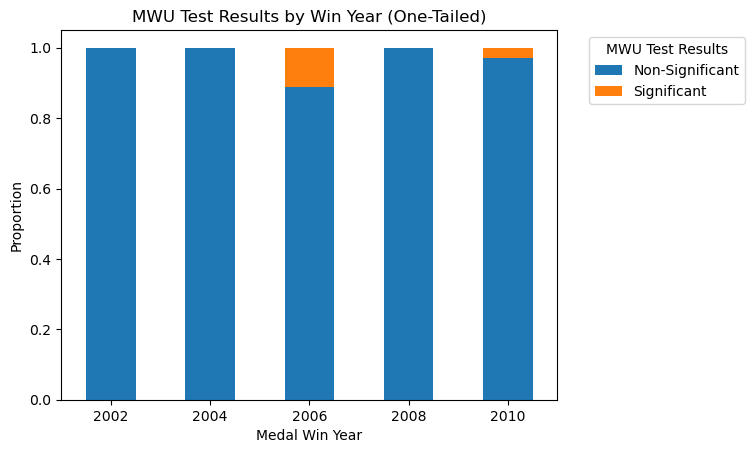

Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)


In [29]:
#now see if the year of the medal win influences the ratings after a medal win
#group the data by the 'win year' and 'result' columns and count the results in each group
year_grouped_results_df = medalwinner_results_df.groupby(['Medal Win Year', 'Result']).size().unstack().fillna(0)

#normalize for proportions
year_grouped_results_df = year_grouped_results_df.div(year_grouped_results_df.sum(axis=1), axis=0)

# Create a stacked bar graph
year_grouped_results_df.plot(kind='bar', stacked=True)
plt.xlabel('Medal Win Year')
plt.ylabel('Proportion')
plt.title('MWU Test Results by Win Year (One-Tailed)')
plt.legend(title='MWU Test Results', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0, fontsize=10)
plt.show()
print('Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)')

In [30]:
#chi-sqaure test if frequency of significant test results better than a coin flip
#calculate observed frequencies by grouping the data by 'Win Year' and 'Result'
observed = medalwinner_results_df.groupby(['Medal Win Year', 'Result']).size().unstack(fill_value=0)

#calculate the total counts within each 'Win Year' category
total_counts = observed.sum(axis=1)

#define the expected frequencies for 'Significant' and 'Non-Significant' as 50%-50%
expected = pd.DataFrame({
    'Significant': total_counts * 0.5,
    'Non-Significant': total_counts * 0.5
})

print(observed)
print(expected)

#perform the chi-square goodness of fit test using the cs function
chi2, p = cs(observed.values.ravel(), expected.values.ravel())

#display the chi-square statistic and p-value
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")

# Determine whether to reject the null hypothesis
alpha = 0.05  # Significance level
if p < alpha:
    print("Reject the null hypothesis: The observed distribution is different from the expected 50%-50% distribution")
else:
    print("Fail to reject the null hypothesis: The observed distribution is not significantly different from the expected 50%-50% distribution")

Result          Non-Significant  Significant
Medal Win Year                              
2002                         17            0
2004                         25            0
2006                         24            3
2008                         37            0
2010                         33            1
                Significant  Non-Significant
Medal Win Year                              
2002                    8.5              8.5
2004                   12.5             12.5
2006                   13.5             13.5
2008                   18.5             18.5
2010                   17.0             17.0
Chi-square statistic: 125.45
P-value: 0.0000
Reject the null hypothesis: The observed distribution is different from the expected 50%-50% distribution


In [31]:
#check to see if time since medal win masks statistical improvement in scores
#initialize a list to store the results
results_nearWin = []

#get unique combinations of 'name' and 'wbc_year_win' from the DataFrame
unique_combinations_nearWin = wbc_medal_merged_df[['name', 'wbc_year_win', 'medal', 'wbc_category']].drop_duplicates()

#loop through each unique combination
for index, row in unique_combinations_nearWin.iterrows():
    name = row['name']
    win_year = row['wbc_year_win']
    medal = row['medal']
    category = row['wbc_category']
    
    #get the two populations of interest for the Mann-Whitney U test (scoreSum before winning a medal and after) - in this case up to two years after a medal win
    population_beforewin_nearWin = wbc_medal_merged_df[(wbc_medal_merged_df['name'] == name) & (wbc_medal_merged_df['year'] <= win_year)]['scoreSum']
    population_afterwin_nearWin = wbc_medal_merged_df[(wbc_medal_merged_df['name'] == name) & (wbc_medal_merged_df['year'] >= win_year + 1) & (wbc_medal_merged_df['year'] <= win_year + 2)]['scoreSum']

    #minimum sample size of three ratings per beer
    if len(population_beforewin_nearWin) < 3 or len(population_afterwin_nearWin) < 3: 
        continue
    
    #perform the one-sided Mann-Whitney U test (we only really care about if the stochastic dominance is > after a medal win)
    statistic_nearWin, p_value_nearWin = st.mannwhitneyu(population_beforewin_nearWin, population_afterwin_nearWin, alternative='less')

    formatted_p_value_nearWin = '{:.6f}'.format(p_value_nearWin)
    
    results_nearWin.append({'Name': name, 'Medal Win Year': win_year, 'Medal Won': medal, 'Win Category': category,  'MWU Test Statistic': statistic_nearWin, 'P-Value': formatted_p_value_nearWin})

# Create a DataFrame from the results list
medalwinner_results_nearWin_df = pd.DataFrame(results_nearWin)

# Display the results for each unique combination of 'name' and 'wbc_win_year'
medalwinner_results_nearWin_df

,Name,Medal Win Year,Medal Won,Win Category,MWU Test Statistic,P-Value
0,kannah creek standing wave pale ale,2008,gold,esb,2.0,0.200000
1,firestone walker hefeweizen,2010,gold,german style hefe,111.5,0.118416
2,nectar ales pale nectar,2004,silver,american pale ale,556.0,0.822789
3,mission street pale ale,2006,silver,american pale ale,2734.0,0.165166
4,mission street pale ale,2010,bronze,american pale ale,6936.0,0.006002
...,...,...,...,...,...,...
133,shiner hefeweizen,2002,bronze,american style wheat,6882.0,0.395362
134,shiner hefeweizen,2006,silver,american style hefe,110964.0,0.999647
135,pyramid crystal wheat,2008,gold,american style wheat,3494.0,0.071040
136,pyramid haywire hefeweizen,2002,silver,american style wheat,39504.0,1.000000


In [32]:
#check for near-win shift in ratings after medal win
#convert our P-values to numbers
medalwinner_results_nearWin_df['P-Value'] = pd.to_numeric(medalwinner_results_nearWin_df['P-Value'], errors='coerce')

#define your significant P-value threshold
significant_threshold = 0.05 / medalwinner_results_nearWin_df['P-Value'].size

#categorize results as significant or non-significant
medalwinner_results_nearWin_df['Result'] = medalwinner_results_nearWin_df['P-Value'].apply(lambda x: 'Significant' if x < significant_threshold else 'Non-Significant')

medalwinner_results_nearWin_df_sig = medalwinner_results_nearWin_df['Result'] == 'Significant'
medalwinner_results_nearWin_sig_df = medalwinner_results_nearWin_df[medalwinner_results_nearWin_df_sig]

medalwinner_results_nearWin_sig_df

,Name,Medal Win Year,Medal Won,Win Category,MWU Test Statistic,P-Value,Result
8,firestone walker pale 31,2010,gold,american pale ale,94531.5,0.000270,Significant
90,dogfish head festina lente,2006,bronze,belgian sour,1934.0,0.000215,Significant
108,russian river pliny the elder,2006,gold,imperial ipa,36895.0,0.000000,Significant


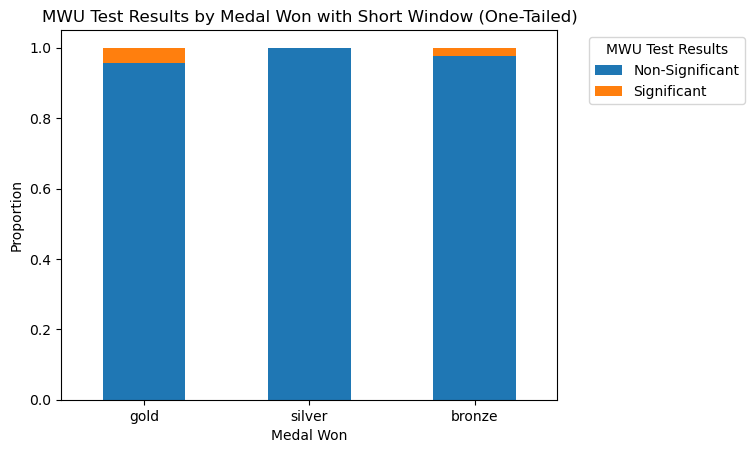

Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)


In [33]:
#group the data by the 'Medal' and 'Result' columns and count the results in each group
medal_grouped_results_nearWin_df = medalwinner_results_nearWin_df.groupby(['Medal Won', 'Result']).size().unstack().fillna(0)

#normalize for proportions
medal_grouped_results_nearWin_df = medal_grouped_results_nearWin_df.div(medal_grouped_results_nearWin_df.sum(axis=1), axis=0)

#define the custom order for the groups
custom_group_order = ['gold', 'silver', 'bronze']

#reindex the grouped_data DataFrame to match the custom order
medal_grouped_results_nearWin_df = medal_grouped_results_nearWin_df.reindex(custom_group_order)

#create a stacked bar graph
medal_grouped_results_nearWin_df.plot(kind='bar', stacked=True)
plt.xlabel('Medal Won')
plt.ylabel('Proportion')
plt.title('MWU Test Results by Medal Won with Short Window (One-Tailed)')
plt.legend(title='MWU Test Results', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()
print('Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)')

In [34]:
#chi-square on score improvement frequency vs a coin flip grouped by the medal won

#calculate observed frequencies by grouping the data by 'Medal Won' and 'Result'
observed = medalwinner_results_nearWin_df.groupby(['Medal Won', 'Result']).size().unstack(fill_value=0)

#calculate the total counts within each 'Medal Won' category
total_counts = observed.sum(axis=1)

#define the expected frequencies for 'Significant' and 'Non-Significant' as 50%-50%
expected = pd.DataFrame({
    'Significant': total_counts * 0.5,
    'Non-Significant': total_counts * 0.5
})

print(observed)
print()
print(expected)

#perform the chi-square goodness of fit test using the cs function
chi2, p = cs(observed.values.ravel(), expected.values.ravel())

#display the chi-square statistic and p-value
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")

#determine whether to reject the null hypothesis
alpha = 0.05  # Significance level
if p < alpha:
    print("Reject the null hypothesis: The observed distribution is different from the expected 50%-50% distribution")
else:
    print("Fail to reject the null hypothesis: The observed distribution is not significantly different from the expected 50%-50% distribution")

Result     Non-Significant  Significant
Medal Won                              
bronze                  41            1
gold                    44            2
silver                  50            0

           Significant  Non-Significant
Medal Won                              
bronze            21.0             21.0
gold              23.0             23.0
silver            25.0             25.0
Chi-square statistic: 126.44
P-value: 0.0000
Reject the null hypothesis: The observed distribution is different from the expected 50%-50% distribution


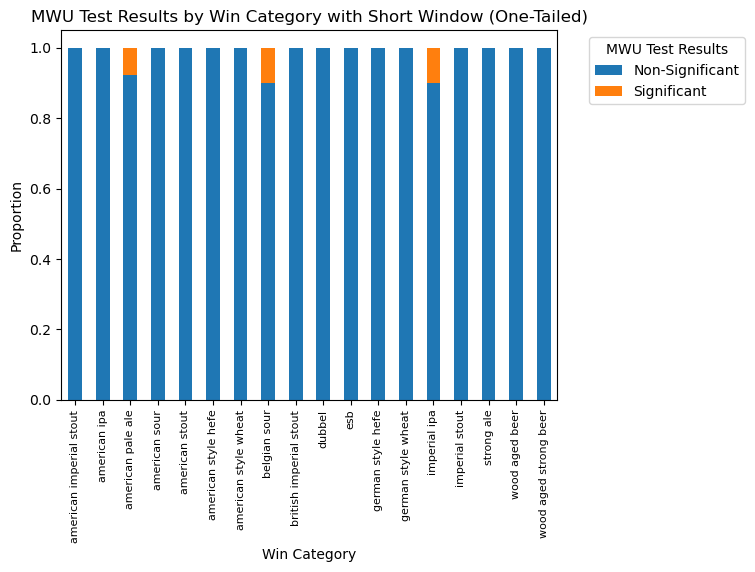

Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)


In [35]:
#group the data by the 'win category' and 'result' columns and count the results in each group
cat_grouped_results_nearWin_df = medalwinner_results_nearWin_df.groupby(['Win Category', 'Result']).size().unstack().fillna(0)

#normalize for proportions
cat_grouped_results_nearWin_df = cat_grouped_results_nearWin_df.div(cat_grouped_results_nearWin_df.sum(axis=1), axis=0)

#create a stacked bar graph
cat_grouped_results_nearWin_df.plot(kind='bar', stacked=True)
plt.xlabel('Win Category')
plt.ylabel('Proportion')
plt.title('MWU Test Results by Win Category with Short Window (One-Tailed)')
plt.legend(title='MWU Test Results', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90, fontsize=8)
plt.show()
print('Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)')

In [36]:
#chi square grouped by win category

#calculate observed frequencies by grouping the data by 'Medal Won' and 'Result'
observed = medalwinner_results_nearWin_df.groupby(['Win Category', 'Result']).size().unstack(fill_value=0)

# Step 2: Calculate the total counts within each 'Medal Won' category
total_counts = observed.sum(axis=1)

# Step 3: Define the expected frequencies for 'Significant' and 'Non-Significant' as 50%-50%
expected = pd.DataFrame({
    'Significant': total_counts * 0.5,
    'Non-Significant': total_counts * 0.5
})

print(observed)
print()
print(expected)

# Step 4: Perform the chi-square goodness of fit test using the cs function
chi2, p = cs(observed.values.ravel(), expected.values.ravel())

# Display the chi-square statistic and p-value
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")

# Determine whether to reject the null hypothesis
alpha = 0.05  # Significance level
if p < alpha:
    print("Reject the null hypothesis: The observed distribution is different from the expected 50%-50% distribution")
else:
    print("Fail to reject the null hypothesis: The observed distribution is not significantly different from the expected 50%-50% distribution")

Result                   Non-Significant  Significant
Win Category                                         
american imperial stout                6            0
american ipa                          14            0
american pale ale                     12            1
american sour                          3            0
american stout                         5            0
american style hefe                    8            0
american style wheat                  10            0
belgian sour                           9            1
british imperial stout                 3            0
dubbel                                 9            0
esb                                    9            0
german style hefe                      5            0
german style wheat                     8            0
imperial ipa                           9            1
imperial stout                         7            0
strong ale                             9            0
wood aged beer              

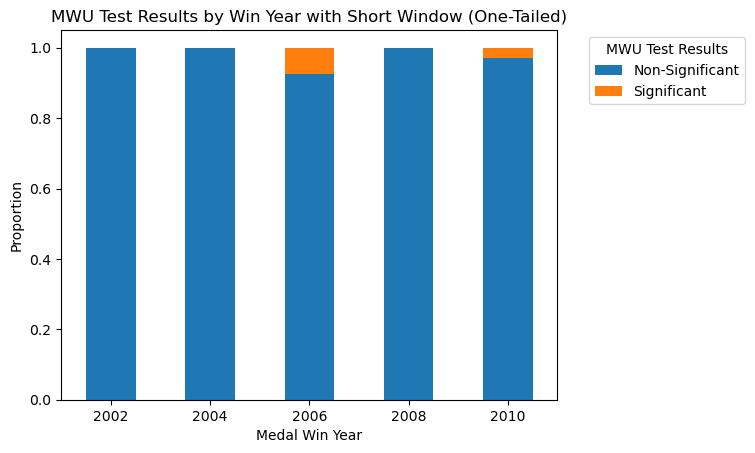

Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)


In [37]:
#group the data and count the results in each group
year_grouped_results_nearWin_df = medalwinner_results_nearWin_df.groupby(['Medal Win Year', 'Result']).size().unstack().fillna(0)

#normalize for proportions
year_grouped_results_nearWin_df = year_grouped_results_nearWin_df.div(year_grouped_results_nearWin_df.sum(axis=1), axis=0)

#create a stacked bar graph
year_grouped_results_nearWin_df.plot(kind='bar', stacked=True)
plt.xlabel('Medal Win Year')
plt.ylabel('Proportion')
plt.title('MWU Test Results by Win Year with Short Window (One-Tailed)')
plt.legend(title='MWU Test Results', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0, fontsize=10)
plt.show()
print('Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)')

In [38]:
#chi-square to test for difference from a coin flip
#calculate observed frequencies by grouping the data by 'Win Year' and 'Result'
observed = medalwinner_results_nearWin_df.groupby(['Medal Win Year', 'Result']).size().unstack(fill_value=0)

#calculate the total counts within each 'Medal Won' category
total_counts = observed.sum(axis=1)

#define the expected frequencies for 'Significant' and 'Non-Significant' as 50%-50%
expected = pd.DataFrame({
    'Significant': total_counts * 0.5,
    'Non-Significant': total_counts * 0.5
})

print(observed)
print(expected)

#perform the chi-square goodness of fit test using the cs function
chi2, p = cs(observed.values.ravel(), expected.values.ravel())

#display the chi-square statistic and p-value
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")

#determine whether to reject the null hypothesis
alpha = 0.05  # Significance level
if p < alpha:
    print("Reject the null hypothesis: The observed distribution is different from the expected 50%-50% distribution")
else:
    print("Fail to reject the null hypothesis: The observed distribution is not significantly different from the expected 50%-50% distribution")

Result          Non-Significant  Significant
Medal Win Year                              
2002                         17            0
2004                         24            0
2006                         25            2
2008                         36            0
2010                         33            1
                Significant  Non-Significant
Medal Win Year                              
2002                    8.5              8.5
2004                   12.0             12.0
2006                   13.5             13.5
2008                   18.0             18.0
2010                   17.0             17.0
Chi-square statistic: 126.71
P-value: 0.0000
Reject the null hypothesis: The observed distribution is different from the expected 50%-50% distribution


In [39]:
#merge the DataFrames on the 'wbctoratebeer_name_brewery' and 'name' columns
wbc_medals_droppedDup_df = wbc_medals_df.drop_duplicates(subset='wbctoratebeer_name_brewery', keep='first')
wbc_medal_wholedataset_merged_df = pd.merge(beer_data_df_cleaned, wbc_medals_droppedDup_df, left_on='name', right_on='wbctoratebeer_name_brewery', how='left')
wbc_medal_wholedataset_merged_df

,name,beerId,brewerId,ABV,style,appearance,aroma,palate,taste,overall,...,profileName,year,parentStyle,scoreSum,wbc_category,wbc_year_win,medal,wbc_name,wbc_brewery,wbctoratebeer_name_brewery
0,john harvards simcoe ipa,63836,8481,5.4,india pale ale &#40;ipa&#41;,4,6,3,6,13,...,hopdog,2006,ipa,32,NaN,NaN,NaN,NaN,NaN,NaN
1,john harvards simcoe ipa,63836,8481,5.4,india pale ale &#40;ipa&#41;,4,6,4,7,13,...,TomDecapolis,2006,ipa,34,NaN,NaN,NaN,NaN,NaN,NaN
2,john harvards cristal pilsner,71716,8481,5.0,bohemian pilsener,4,5,3,6,14,...,PhillyBeer2112,2000,czech lager,32,NaN,NaN,NaN,NaN,NaN,NaN
3,john harvards fancy lawnmower beer,64125,8481,5.4,kölsch,2,4,2,4,8,...,TomDecapolis,2006,pale bitter european beer,20,NaN,NaN,NaN,NaN,NaN,NaN
4,john harvards fancy lawnmower beer,64125,8481,5.4,kölsch,2,4,2,4,8,...,hopdog,2006,pale bitter european beer,20,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750504,oakhill mendip twister,12240,1028,6.3,stout,3,7,3,7,15,...,rauchbier,2002,american porter and stout,35,NaN,NaN,NaN,NaN,NaN,NaN
2750505,oakhill yeoman 1767 strong ale,5677,1028,5.0,premium bitter/esb,4,5,3,6,12,...,imdownthepub,2004,british bitter,30,NaN,NaN,NaN,NaN,NaN,NaN
2750506,oakhill yeoman 1767 strong ale,5677,1028,5.0,premium bitter/esb,4,4,3,6,13,...,SilkTork,2003,british bitter,30,NaN,NaN,NaN,NaN,NaN,NaN
2750507,oakhill yeoman 1767 strong ale,5677,1028,5.0,premium bitter/esb,3,5,2,5,10,...,omhper,2002,british bitter,25,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
#check to see if an award winning beer score better than other beers in the brewery's portfolio
award_winners = wbc_medal_wholedataset_merged_df[wbc_medal_wholedataset_merged_df['medal'].notna()]

port_results = []
port_processed_beers = set()  # Store the unique beers that have been processed

for index, winner in award_winners.iterrows():
    beer_name = winner['name']
    brewer_id = winner['brewerId']
    
    #check if this beer has already been processed
    if beer_name in port_processed_beers:
        continue  #skip processing if already processed
    
    #select ratings for the award-winning beer
    winner_ratings = wbc_medal_wholedataset_merged_df.loc[wbc_medal_wholedataset_merged_df['name'] == beer_name, 'scoreSum']
    
    #select ratings for all other beers with the same brewerId
    other_beers_ratings = wbc_medal_wholedataset_merged_df[(wbc_medal_wholedataset_merged_df['name'] != beer_name) & (wbc_medal_wholedataset_merged_df['brewerId'] == brewer_id)]['scoreSum']
    
    #perform the Mann-Whitney U test - one tailed since we only care if winning beers have a stochastic dominance > than non-winning beers
    stat, p = st.mannwhitneyu(winner_ratings, other_beers_ratings, alternative='greater') 
    
    formatted_p_value = '{:.6f}'.format(p)
    
    port_results.append({
        'Beer Name': beer_name,
        'Brewer ID': brewer_id,
        'Mann-Whitney U Statistic': stat,
        'P-Value': formatted_p_value,
    })
    
    # Mark this beer as processed
    port_processed_beers.add(beer_name)

# Create a DataFrame from the results
brewerPort_results_df = pd.DataFrame(port_results)

# Display the results
brewerPort_results_df

,Beer Name,Brewer ID,Mann-Whitney U Statistic,P-Value
0,kannah creek standing wave pale ale,7314,286.0,0.099302
1,high desert imperial stout,3500,126.0,0.004803
2,firestone walker hefeweizen,398,89703.5,0.999996
3,nectar ales pale nectar,398,282955.0,0.999864
4,mission street pale ale,398,337925.0,1.000000
...,...,...,...,...
125,shiner dunkelweizen &#40;winter ale&#41;,149,718103.5,0.000028
126,shiner hefeweizen,149,1663131.0,0.467902
127,iron hill raspberry torte,5906,183.5,0.308656
128,pyramid crystal wheat,154,271201.5,0.999889


In [41]:
#convert our P-values to numbers
brewerPort_results_df['P-Value'] = pd.to_numeric(brewerPort_results_df['P-Value'], errors='coerce')

#define your significant P-value threshold
significant_threshold = 0.05 / brewerPort_results_df['P-Value'].size

#categorize results as significant or non-significant
brewerPort_results_df['Result'] = brewerPort_results_df['P-Value'].apply(lambda x: 'Significant' if x < significant_threshold else 'Non-Significant')

brewerPort_results_df_sig = brewerPort_results_df['Result'] == 'Significant'
brewerPort_results_sig_df = brewerPort_results_df[brewerPort_results_df_sig]

brewerPort_results_sig_df

,Beer Name,Brewer ID,Mann-Whitney U Statistic,P-Value,Result
5,firestone walker union jack ipa,398,3100505.0,0.000000,Significant
7,iron hill russian imperial stout,5907,145079.5,0.000000,Significant
12,allagash curieux,525,4760998.5,0.000000,Significant
14,stone ruination ipa,76,62875434.0,0.000000,Significant
15,alpine beer company pure hoppiness,2776,1079515.5,0.000000,Significant
16,alpine beer company duet,2776,622471.0,0.000000,Significant
19,pizza port poormans ipa,1538,313347.5,0.000000,Significant
20,pizza port frank double ipa,1538,452808.5,0.000000,Significant
21,pizza port night rider,1538,307751.0,0.000000,Significant
25,ballast point dorado double ipa,434,1770869.5,0.000000,Significant


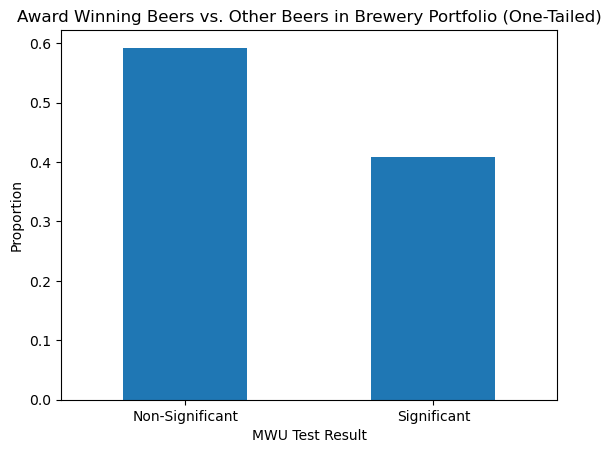

Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)
The lack of consistently more frequent significant results suggests that award winning beers do not regularly outperform their intrabrewery peers in consumer ratings.


In [54]:
# Group the data and count the results in each group
brewerPort_grouped_results_df = brewerPort_results_df.groupby(['Result']).size().fillna(0)

#normalize for proportions
brewerPort_grouped_results_df = brewerPort_grouped_results_df.div(brewerPort_grouped_results_df.sum())

# Create a stacked bar graph
brewerPort_grouped_results_df.plot(kind='bar')
plt.xlabel('MWU Test Result')
plt.ylabel('Proportion')
plt.title('Award Winning Beers vs. Other Beers in Brewery Portfolio (One-Tailed)')
plt.xticks(rotation=0, fontsize=10)
plt.show()
print('Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)')
print('The lack of consistently more frequent significant results suggests that award winning beers do not regularly outperform their intrabrewery peers in consumer ratings.')

In [43]:
#check if an award winning beer gets higher ratings than other beers in the parent category
award_winners = wbc_medal_wholedataset_merged_df[wbc_medal_wholedataset_merged_df['medal'].notna()]

cat_results = []
cat_processed_beers = set()  # Store the unique beers that have been processed

for index, winner in award_winners.iterrows():
    beer_name = winner['name']
    brewer_id = winner['brewerId']
    p_style = winner['parentStyle']
    
    # Check if this beer has already been processed
    if beer_name in cat_processed_beers:
        continue  # Skip processing if already processed
    
    # Select ratings for the award-winning beer
    winner_ratings = wbc_medal_wholedataset_merged_df.loc[wbc_medal_wholedataset_merged_df['name'] == beer_name, 'scoreSum']
    
    # Select ratings for all other beers with the same parent style
    other_beers_ratings = wbc_medal_wholedataset_merged_df[(wbc_medal_wholedataset_merged_df['name'] != beer_name) & (wbc_medal_wholedataset_merged_df['parentStyle'] == p_style)]['scoreSum']
    
    # Perform the Mann-Whitney U test
    stat, p = st.mannwhitneyu(winner_ratings, other_beers_ratings, alternative='greater') 
    
    formatted_p_value = '{:.6f}'.format(p)
    
    cat_results.append({
        'Beer Name': beer_name,
        'Brewer ID': brewer_id,
        'Mann-Whitney U Statistic': stat,
        'P-Value': formatted_p_value,
    })
    
    # Mark this beer as processed
    cat_processed_beers.add(beer_name)

# Create a DataFrame from the results
cat_brewer_results_df = pd.DataFrame(cat_results)

# Display the results
cat_brewer_results_df

,Beer Name,Brewer ID,Mann-Whitney U Statistic,P-Value
0,kannah creek standing wave pale ale,7314,970373.0,0.030843
1,high desert imperial stout,3500,873828.5,0.123790
2,firestone walker hefeweizen,398,1964947.5,0.267629
3,nectar ales pale nectar,398,9975242.5,0.000000
4,mission street pale ale,398,15388639.5,0.588723
...,...,...,...,...
125,shiner dunkelweizen &#40;winter ale&#41;,149,6337343.0,1.000000
126,shiner hefeweizen,149,35741386.5,0.083975
127,iron hill raspberry torte,5906,16192.0,0.677685
128,pyramid crystal wheat,154,6371082.5,0.004404


In [44]:
#convert our P-values to numbers
cat_brewer_results_df['P-Value'] = pd.to_numeric(cat_brewer_results_df['P-Value'], errors='coerce')

#define your significant P-value threshold
significant_threshold = 0.05 / cat_brewer_results_df['P-Value'].size

#categorize results as significant or non-significant
cat_brewer_results_df['Result'] = cat_brewer_results_df['P-Value'].apply(lambda x: 'Significant' if x < significant_threshold else 'Non-Significant')

cat_brewer_results_df_sig = cat_brewer_results_df['Result'] == 'Significant'
cat_brewer_results_sig_df = cat_brewer_results_df[cat_brewer_results_df_sig]

cat_brewer_results_sig_df

,Beer Name,Brewer ID,Mann-Whitney U Statistic,P-Value,Result
3,nectar ales pale nectar,398,9975242.5,0.000000,Significant
5,firestone walker union jack ipa,398,89670555.5,0.000000,Significant
6,firestone walker pale 31,398,45122863.5,0.000000,Significant
7,iron hill russian imperial stout,5907,44589239.5,0.000000,Significant
10,oggis black magic stout,455,7485027.0,0.000000,Significant
12,allagash curieux,525,53489867.5,0.000000,Significant
13,stone pale ale,76,151278321.0,0.000000,Significant
14,stone ruination ipa,76,521842512.0,0.000000,Significant
15,alpine beer company pure hoppiness,2776,94618738.0,0.000000,Significant
16,alpine beer company duet,2776,42875423.5,0.000000,Significant


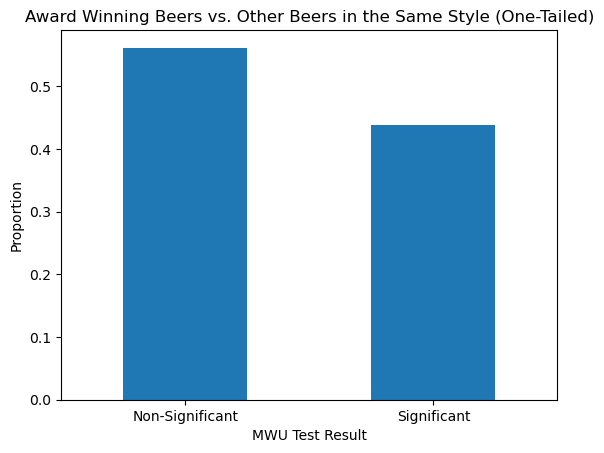

Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)
The lack of consistently more frequent significant results suggests that award winning beers do not regularly outperform their style peers in consumer ratings.


In [53]:
# Group the data and count the results in each group
cat_brewer_grouped_results_df = cat_brewer_results_df.groupby(['Result']).size().fillna(0)

#normalize for proportions
cat_brewer_grouped_results_df = cat_brewer_grouped_results_df.div(cat_brewer_grouped_results_df.sum())

# Create a stacked bar graph
cat_brewer_grouped_results_df.plot(kind='bar')
plt.xlabel('MWU Test Result')
plt.ylabel('Proportion')
plt.title('Award Winning Beers vs. Other Beers in the Same Style (One-Tailed)')
plt.xticks(rotation=0, fontsize=10)
plt.show()
print('Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)')
print('The lack of consistently more frequent significant results suggests that award winning beers do not regularly outperform their style peers in consumer ratings.')

In [46]:
# Filter the award-winning beers
award_winners = wbc_medal_wholedataset_merged_df[wbc_medal_wholedataset_merged_df['medal'].notna()]

port_cat_results = []

for brewer_id in award_winners['brewerId'].unique():
    # Select ratings for all beers with the same brewerId (beers brewed by the award-winning brewery)
    brewery_beers = wbc_medal_wholedataset_merged_df[wbc_medal_wholedataset_merged_df['brewerId'] == brewer_id]
    
    # Extract the unique parent styles associated with the award-winning brewery
    unique_parentstyles = brewery_beers['parentStyle'].unique()
    
    # Select ratings for all other beers in the dataset that have a parent style matching the unique styles of the award-winning brewery
    matching_parentstyle_ratings = wbc_medal_wholedataset_merged_df[wbc_medal_wholedataset_merged_df['parentStyle'].isin(unique_parentstyles) & (wbc_medal_wholedataset_merged_df['brewerId'] != brewer_id)]['scoreSum']
    
    # Perform the Mann-Whitney U test with the 'greater' alternative hypothesis
    stat, p = st.mannwhitneyu(brewery_beers['scoreSum'], matching_parentstyle_ratings, alternative='greater')
    
    formatted_p_value = '{:.6f}'.format(p)
        
    port_cat_results.append({
        'Brewer ID': brewer_id,
        'Parent Styles': unique_parentstyles,
        'Mann-Whitney U Statistic': stat,
        'P-Value': formatted_p_value,
    })

# Create a DataFrame from the results
port_cat_results_df = pd.DataFrame(port_cat_results)

# Display the results
port_cat_results_df

,Brewer ID,Parent Styles,Mann-Whitney U Statistic,P-Value
0,7314,"[pale american ale, amber and brown american b...",2.636919e+07,0.998967
1,3500,"[strong american ale, pale american ale, germa...",1.715466e+07,0.674568
2,398,"[american porter and stout, strong american al...",9.512506e+09,0.000000
3,5907,"[monastic ale, international lager, belgian al...",1.498175e+09,0.000000
4,455,"[strong american ale, scottish ale, strong bri...",3.130450e+09,0.000000
...,...,...,...,...
93,8636,"[strong american ale, strong european beer, am...",9.369372e+08,0.000000
94,205,"[international lager, strong american ale, pal...",1.716694e+10,0.000000
95,149,"[international lager, standard american beer, ...",2.016793e+09,1.000000
96,5906,"[american porter and stout, strong british ale...",1.458736e+08,0.999778


In [47]:
#convert our P-values to numbers
port_cat_results_df['P-Value'] = pd.to_numeric(port_cat_results_df['P-Value'], errors='coerce')

#define your significant P-value threshold
significant_threshold = 0.05 / port_cat_results_df['P-Value'].size

#categorize results as significant or non-significant
port_cat_results_df['Result'] = port_cat_results_df['P-Value'].apply(lambda x: 'Significant' if x < significant_threshold else 'Non-Significant')

port_cat_results_df_sig = port_cat_results_df['Result'] == 'Significant'
port_cat_results_sig_df = port_cat_results_df[port_cat_results_df_sig]

port_cat_results_sig_df

,Brewer ID,Parent Styles,Mann-Whitney U Statistic,P-Value,Result
2,398,"[american porter and stout, strong american al...",9.512506e+09,0.000000,Significant
3,5907,"[monastic ale, international lager, belgian al...",1.498175e+09,0.000000,Significant
4,455,"[strong american ale, scottish ale, strong bri...",3.130450e+09,0.000000,Significant
5,525,"[strong belgian ale, american wild ale, europe...",5.852480e+09,0.000000,Significant
6,76,"[ipa, american porter and stout, monastic ale,...",5.263037e+10,0.000000,Significant
7,2776,"[strong american ale, ipa, american wild ale, ...",4.175270e+09,0.000000,Significant
9,1538,"[ipa, strong american ale, american porter and...",4.605340e+09,0.000000,Significant
10,282,"[international lager, dark european lager, sta...",4.285626e+09,0.000000,Significant
11,234,"[american porter and stout, strong american al...",6.879843e+09,0.000000,Significant
12,434,"[strong american ale, pale american ale, ameri...",8.032919e+09,0.000000,Significant


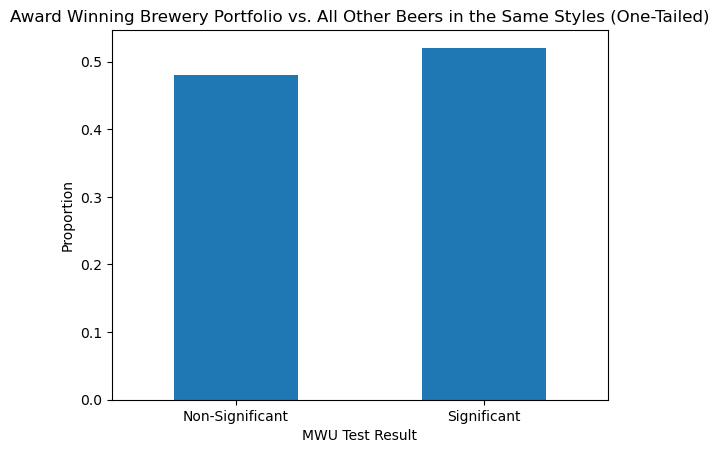

Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)
The lack of consistently more frequent significant results suggests that award winning breweries do not consistently outperform their peers in consumer ratings.


In [52]:
# Group the data and count the results in each group
port_cat_grouped_results_df = port_cat_results_df.groupby(['Result']).size().fillna(0)

#normalize for proportions
port_cat_grouped_results_df = port_cat_grouped_results_df.div(port_cat_grouped_results_df.sum())

# Create a stacked bar graph
port_cat_grouped_results_df.plot(kind='bar')
plt.xlabel('MWU Test Result')
plt.ylabel('Proportion')
plt.title('Award Winning Brewery Portfolio vs. All Other Beers in the Same Styles (One-Tailed)')
plt.xticks(rotation=0, fontsize=10)
plt.show()
print('Proportion of significant vs. non-significant Mann-Whitney U test results (Bonferroni corrected)')
print('The lack of consistently more frequent significant results suggests that award winning breweries do not consistently outperform their peers in consumer ratings.')